# Model 1 - circular fingerprint features 1024 - H20 autoML - Model Interpretation



In [ ]:
# Import data leakage prevention utilities
import sys
import warnings
warnings.filterwarnings('ignore')

# Import custom utilities for data leakage prevention
from qsar_utils_no_leakage import (
    QSARDataProcessor,
    ScaffoldSplitter,
    plot_similarity_distribution,
    print_leakage_prevention_summary
)

print("✅ Data leakage prevention utilities loaded successfully!")
print("\n" + "="*70)
print_leakage_prevention_summary()

## 🛡️ Data Leakage Prevention - CRITICAL FIXES

**This notebook has been updated to prevent data leakage using:**

1. ✅ **Scaffold-based splitting** (not random!)
2. ✅ **Duplicate removal BEFORE splitting**
3. ✅ **Near-duplicate detection** (Tanimoto ≥ 0.95)
4. ✅ **Fingerprints generated per split**
5. ✅ **Feature scaling on train only**
6. ✅ **Bayesian optimization with scaffold-based CV**
7. ✅ **Similarity analysis** (train-test)

**Key Changes:**
- Random K-Fold → Scaffold-based splitting
- GP hyperparameters tuned with scaffold-based CV
- Fingerprints scaled correctly (fit on train only)

---

In [ ]:
#!git clone https://github.com/swansonk14/admet_ai.git
#%cd admet_ai


In [ ]:
#!pip install -r requirements.txt
#!pip install -e .

In [ ]:
#from admet_ai import ADMETModel

#model = ADMETModel()
#preds = model.predict(smiles="O(c1ccc(cc1)CCOC)CC(O)CNC(C)C")

In [ ]:
#preds

## Data loading and Preprocessing



In [ ]:
import multiprocessing

print("Number of CPU cores:", multiprocessing.cpu_count())

Number of CPU cores: 2


In [ ]:
# For Reporducibility
import numpy as np
np.random.seed(42)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load dataset
import pandas as pd
df=pd.read_excel('/content/drive/MyDrive/DrRoyRationalDesign/Input of triazole and cysteine_datasheet.xlsx')
df

,Identifier,Canonical SMILES,IC50 uM,PIC50
0,TB-VS0012,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N2C)=...,5.3,5.275724
1,TB-VS12-2,BrC1=CC(C2=NN=C(N2C)S)=CN=C1,200,3.698970
2,TB-VS12-3,BrC1=CC(C2=NN=C(N2C)SCC3=CC=C(C=C3)Cl)=CN=C1,200,3.698970
3,TB-VS12-4,CCCCCCC#CC1=CC(C2=NN=C(N2C)S)=CN=C1,22.57,4.646468
4,TB-VS12-5,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=CC=C3)N2C)=CN=C1,175,3.756962
...,...,...,...,...
185,ROY-0000225-001,CC(OC(N1CC(OCCCC2=CC=CC=C2)C1)=O)(C)C,148,3.829738
186,ROY-0000224-001,CCCCCCOC(C1)CN1C(OC(C)(C)C)=O,>200,NaN
187,ROY-0000177-001,BrC1=CC(C#CC2=CC=CC=C2)=CN=C1,>200,NaN
188,ROY-0000176-001,FC(F)(F)OC(C=C1)=CC=C1C#CC2=CN=CC(Br)=C2,>200,NaN


In [ ]:
pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 21.2 MB/s eta 0:00:00


In [ ]:
# ✅ FIXED: Proper duplicate handling to prevent leakage
import pandas as pd
from rdkit import Chem

print(f"📊 Original dataset: {len(df)} rows")

# Initialize the QSAR data processor
processor = QSARDataProcessor(smiles_col='Canonical SMILES', target_col='IC50 uM')

# Step 1: Canonicalize SMILES (ensures consistency)
df = processor.canonicalize_smiles(df)

# Step 2: Remove exact duplicates BEFORE splitting (prevents leakage!)
df = processor.remove_duplicates(df, strategy='average')

print(f"\n✅ Clean dataset ready: {len(df)} unique molecules")

# Keep this for backward compatibility
unique_df = df.copy()
numeric_df = df.copy()

Duplicate molecules found:
     Identifier                                   Canonical SMILES IC50 uM  \
138   TB-LCA-33  ClC1=CC=C(CS(C[C@H](N)C(NC(C=C2)=CC=C2C3=CC=CC...     200   
147   TB-LCA-34  ClC1=CC=C(CS(C[C@H](N)C(NC(C=C2)=CC=C2C3=CC=CC...     200   
90   TB-VS12-97  O=C1NC(C=CN1[C@@H]2O[C@H](CSC3=NN=C(C4=CC(C#CC...   97.71   
94   TB-VS12-97  O=C1NC(C=CN1[C@@H]2O[C@H](CSC3=NN=C(C4=CC(C#CC...   97.71   

        PIC50  
138  3.698970  
147  3.698970  
90   4.010061  
94   4.010061  


In [ ]:
unique_df

,Identifier,Canonical SMILES,IC50 uM,PIC50
0,TB-VS0012,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N2C)=...,5.3,5.275724
1,TB-VS12-2,BrC1=CC(C2=NN=C(N2C)S)=CN=C1,200,3.698970
2,TB-VS12-3,BrC1=CC(C2=NN=C(N2C)SCC3=CC=C(C=C3)Cl)=CN=C1,200,3.698970
3,TB-VS12-4,CCCCCCC#CC1=CC(C2=NN=C(N2C)S)=CN=C1,22.57,4.646468
4,TB-VS12-5,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=CC=C3)N2C)=CN=C1,175,3.756962
...,...,...,...,...
185,ROY-0000225-001,CC(OC(N1CC(OCCCC2=CC=CC=C2)C1)=O)(C)C,148,3.829738
186,ROY-0000224-001,CCCCCCOC(C1)CN1C(OC(C)(C)C)=O,>200,NaN
187,ROY-0000177-001,BrC1=CC(C#CC2=CC=CC=C2)=CN=C1,>200,NaN
188,ROY-0000176-001,FC(F)(F)OC(C=C1)=CC=C1C#CC2=CN=CC(Br)=C2,>200,NaN


In [ ]:
unique_df['IC50 uM'].value_counts()

,count
IC50 uM,
200,35
>200,5
250,4
100,3
25.12,2
...,...
6.843,1
5.615,1
9.705,1


In [ ]:
unique_df['IC50 uM'].isna().sum()


np.int64(6)

In [ ]:
# Keep only rows where IC50 uM is numeric
mask = pd.to_numeric(df["IC50 uM"], errors="coerce").notna()
df = df[mask].reset_index(drop=True)

print(f"✅ Final clean dataset: {len(df)} molecules with valid IC50 values")

# Keep for backward compatibility
numeric_df = df.copy()

In [ ]:
numeric_df

,Identifier,Canonical SMILES,IC50 uM,PIC50
0,TB-VS0012,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N2C)=...,5.3,5.275724
1,TB-VS12-2,BrC1=CC(C2=NN=C(N2C)S)=CN=C1,200,3.698970
2,TB-VS12-3,BrC1=CC(C2=NN=C(N2C)SCC3=CC=C(C=C3)Cl)=CN=C1,200,3.698970
3,TB-VS12-4,CCCCCCC#CC1=CC(C2=NN=C(N2C)S)=CN=C1,22.57,4.646468
4,TB-VS12-5,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=CC=C3)N2C)=CN=C1,175,3.756962
...,...,...,...,...
181,ROY-0000175-001,CC(OC(N(C1)CC21CCN(C3=CC(C#CC4=CC=CC=C4)=CN=C3...,6.843,5.164753
183,ROY-0000223-001,ClC(C=C1)=CC=C1CO[C@H](CC2)CN2C3=CC(C#CC4=CC=C...,5.615,5.250650
184,ROY-0000222-001,ClC(C=C1)=CC=C1CO[C@H](CC2)CN2C3=CC(C#CC4=CC=C...,9.705,5.013004
185,ROY-0000225-001,CC(OC(N1CC(OCCCC2=CC=CC=C2)C1)=O)(C)C,148,3.829738


# Standarization

/tmp/ipython-input-1330070655.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df[col] = numeric_df[col].astype(str).str.replace(">", "", regex=False)
/tmp/ipython-input-1330070655.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df[col] = numeric_df[col].astype(str).str.replace("<", "", regex=False)
/tmp/ipython-input-1330070655.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



UNIVARIATE ANALYSIS: IC50 UΜ


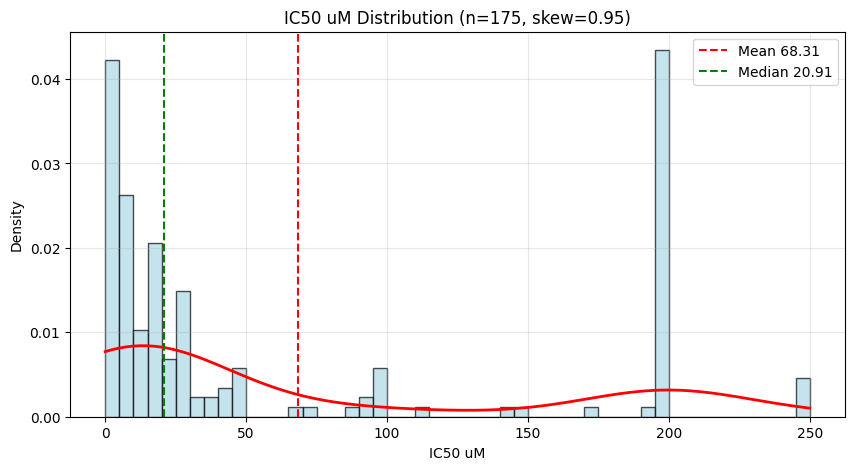

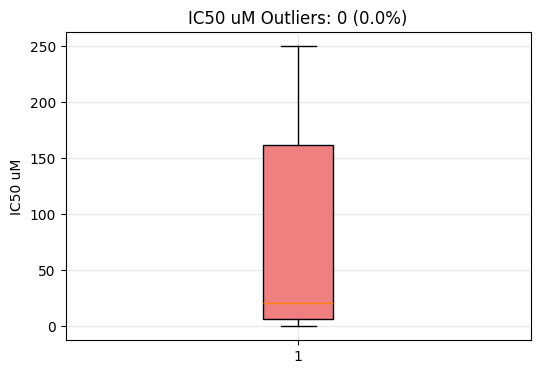


STATISTICAL SUMMARY
   Count    Mean  Median     Std    Min    Max    Range     Q1     Q3  \
0    175  68.306   20.91  82.996  0.048  250.0  249.952  6.373  161.5   

       IQR  Skewness  Kurtosis  Outliers  Outlier %  Normal p-value  \
0  155.128     0.947    -0.865         0        0.0             0.0   

   Likely Normal  
0          False  

INSIGHTS & RECOMMENDATIONS
- Moderately skewed — consider a transform.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Column name
col = "IC50 uM"

# =============================
# CLEAN + CONVERT TO NUMERIC
# =============================
# Remove ">" or "<" signs if present (common in IC50 datasets)
numeric_df[col] = numeric_df[col].astype(str).str.replace(">", "", regex=False)
numeric_df[col] = numeric_df[col].astype(str).str.replace("<", "", regex=False)

# Convert to numeric safely
numeric_df[col] = pd.to_numeric(numeric_df[col], errors='coerce')

# Drop NaNs
data = numeric_df[col].dropna()

print("UNIVARIATE ANALYSIS: IC50 UΜ")
print("="*60)

# =============================
# HISTOGRAM + KDE + MEAN/MEDIAN
# =============================
plt.figure(figsize=(10,5))

# Histogram
plt.hist(data, bins=50, density=True, alpha=0.7,
         color='lightblue', edgecolor='black')

# KDE (if enough data)
if len(data) > 10:
    try:
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(data)
        x = np.linspace(data.min(), data.max(), 200)
        plt.plot(x, kde(x), 'r-', linewidth=2)
    except:
        pass

plt.axvline(data.mean(), color='red', linestyle='--', label=f"Mean {data.mean():.2f}")
plt.axvline(data.median(), color='green', linestyle='--', label=f"Median {data.median():.2f}")

plt.title(f"{col} Distribution (n={len(data)}, skew={data.skew():.2f})")
plt.xlabel(col)
plt.ylabel("Density")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# =============================
# BOX PLOT + OUTLIER ANALYSIS
# =============================
plt.figure(figsize=(6,4))
bp = plt.boxplot(data, patch_artist=True)
bp['boxes'][0].set_facecolor('lightcoral')

Q1, Q3 = data.quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
outliers = data[(data < lower) | (data > upper)]
out_pct = len(outliers) * 100 / len(data)

plt.title(f"{col} Outliers: {len(outliers)} ({out_pct:.1f}%)")
plt.ylabel(col)
plt.grid(alpha=0.3)
plt.show()

# =============================
# STATISTICAL SUMMARY TABLE
# =============================
print("\nSTATISTICAL SUMMARY")
print("="*60)

row = {
    "Count": len(data),
    "Mean": data.mean(),
    "Median": data.median(),
    "Std": data.std(),
    "Min": data.min(),
    "Max": data.max(),
    "Range": data.max() - data.min(),
    "Q1": Q1,
    "Q3": Q3,
    "IQR": IQR,
    "Skewness": data.skew(),
    "Kurtosis": data.kurtosis(),
    "Outliers": len(outliers),
    "Outlier %": out_pct
}

# Normality test (if enough samples)
if len(data) >= 8:
    stat, p = stats.normaltest(data)
    row["Normal p-value"] = p
    row["Likely Normal"] = p > 0.05
else:
    row["Normal p-value"] = np.nan
    row["Likely Normal"] = "Insufficient data"

summary_df = pd.DataFrame([row])
print(summary_df.round(3))

# =============================
# INSIGHTS & RECOMMENDATIONS
# =============================
print("\nINSIGHTS & RECOMMENDATIONS")
print("="*60)

skew = row["Skewness"]
std = row["Std"]
rng = row["Range"]

recommendations = []

# Skewness
if abs(skew) > 2:
    recommendations.append("Highly skewed — consider log transform.")
elif abs(skew) > 0.5:
    recommendations.append("Moderately skewed — consider a transform.")

# Outlier presence
if out_pct > 10:
    recommendations.append("High outlier rate — consider robust models.")
elif out_pct > 5:
    recommendations.append("Moderate number of outliers — evaluate model impact.")

# Range vs Std
if std > 0 and rng > 100 * std:
    recommendations.append("Very wide dynamic range — consider scaling.")

if not recommendations:
    recommendations.append("Data appears well-behaved.")

for r in recommendations:
    print("-", r)


In [ ]:
!pip install deepchem

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.4/552.4 kB 8.1 MB/s eta 0:00:00


In [ ]:
!pip install umap-learn

In [ ]:
numeric_df['Canonical SMILES'].isna().sum()

np.int64(0)

In [ ]:
from rdkit import Chem

# Add a column to indicate validity
numeric_df['valid_smiles'] = numeric_df['Canonical SMILES'].apply(lambda s: Chem.MolFromSmiles(s) is not None)

# Print invalid SMILES
invalid_smiles = numeric_df.loc[~numeric_df['valid_smiles'], 'Canonical SMILES']
for idx, s in invalid_smiles.items():
    print(f"Row {idx}: {s}")



Row 68: ClC1=CC=C(CSC[C@H]([NH3]Cl)C(NC2=CC(C#CCCCCCC)=CN=C2)=O)C=C1
Row 69: ClC1=CC=C(CSC[C@H]([NH3]Cl)C(NC2=CC=C(F)C(F)=C2)=O)C=C1
Row 125: ClC1=CC=C(CSC[C@H]([NH3]Cl)C(NC(C=C2)=CC=C2C3=CC=CC=C3)=O)C=C1
Row 130: O=C(NC1=CC=C(C2=CC=CC=C2)C=C1)[C@@H]([NH3]Cl)CSCC3=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C3
Row 132: O=C(NC1=CC=C(C2=CC=CC=C2)C=C1)[C@@H]([NH3]Cl)CSCC3=CC=C(C(F)(F)F)C=C3
Row 134: O=C(NC1=CC(C#CCCCCCC)=CN=C1)C(CC2=CC=C(Cl)C=C2)[NH3]Cl
Row 139: O=C(NC1=CC(C#CCCCCCC)=CN=C1)[C@@H]([NH3]Cl)CC2=CC=CC=C2
Row 141: ClC1=CC=C(CSC[C@@H]([NH3]Cl)C(NC(C=C2)=CC=C2C3=CC=CC=C3)=O)C=C1
Row 144: FC(C(F)=C1)=CC=C1NC([C@H](CSCC2=CC=C(C=C2)Cl)[NH3]Cl)=O
Row 145: O=C(N[C@H]1CCCCNC1=O)[C@@H]([NH3]Cl)CSCC2=CC=C(Cl)C=C2
Row 153: N[C@H](C(NC1=CC=C(OCCCCC2=CN(CCCNC3=CC=C([N]([O])=O)C4=NON=C34)N=N2)C=C1)=O)CSCC5=CC=C(Cl)C=C5


[21:14:00] Explicit valence for atom # 9 N, 5, is greater than permitted
[21:14:00] Explicit valence for atom # 9 N, 5, is greater than permitted
[21:14:01] Explicit valence for atom # 9 N, 5, is greater than permitted
[21:14:01] Explicit valence for atom # 16 N, 5, is greater than permitted
[21:14:01] Explicit valence for atom # 16 N, 5, is greater than permitted
[21:14:01] Explicit valence for atom # 26 N, 5, is greater than permitted
[21:14:01] Explicit valence for atom # 18 N, 5, is greater than permitted
[21:14:01] Explicit valence for atom # 9 N, 5, is greater than permitted
[21:14:01] Explicit valence for atom # 21 N, 5, is greater than permitted
[21:14:01] Explicit valence for atom # 12 N, 5, is greater than permitted
[21:14:01] Explicit valence for atom # 24 N, 4, is greater than permitted
/tmp/ipython-input-2824881968.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

In [ ]:
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

def fix_protonation_and_nitro(smiles: str) -> str:
    """Automatically fix common RDKit parsing issues for ammonium salts and nitro groups."""
    if not smiles:
        return smiles
    # Fix ammonium hydrochloride
    smiles = smiles.replace('[NH3]Cl', '[NH3+]Cl')
    smiles = smiles.replace('[NH3]Cl', '[NH3+]Cl')  # repeat in case multiple occurrences

    # Fix nitro groups
    smiles = smiles.replace('[N]([O])=O', '[N+](=O)[O-]')
    smiles = smiles.replace('[N]([O-])=O', '[N+](=O)[O-]')  # additional common form

    return smiles

def standardize_mol(mol, verbose=False):
    from rdkit.Chem.MolStandardize import rdMolStandardize

    clean_mol = rdMolStandardize.Cleanup(mol)
    if verbose:
        print('Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:')

    parent_clean_mol = rdMolStandardize.FragmentParent(clean_mol)
    if verbose:
        print('Select the "parent" fragment:')

    uncharger = rdMolStandardize.Uncharger()
    uncharged_parent_clean_mol = uncharger.uncharge(parent_clean_mol)
    if verbose:
        print('Neutralize the molecule:')

    te = rdMolStandardize.TautomerEnumerator()
    taut_uncharged_parent_clean_mol = te.Canonicalize(uncharged_parent_clean_mol)
    if verbose:
        print('Enumerate tautomers:')
    assert taut_uncharged_parent_clean_mol is not None

    if verbose:
        print(Chem.MolToSmiles(taut_uncharged_parent_clean_mol))
    return taut_uncharged_parent_clean_mol

def standardize_smiles(smiles, verbose=False):
    """Fix common parsing issues, then standardize molecule."""
    if verbose: print("Original:", smiles)

    fixed_smiles = fix_protonation_and_nitro(smiles)
    mol = Chem.MolFromSmiles(fixed_smiles)
    if mol is None:
        if verbose:
            print("Failed to parse even after automatic fixes:", fixed_smiles)
        return None

    std_mol = standardize_mol(mol, verbose=verbose)
    return Chem.MolToSmiles(std_mol)

def draw_mol_with_SVG(mol, molSize=(450,150)):
    """Draw RDKit molecule as SVG."""
    mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0], molSize[1])
    drawer.DrawMolecule(mc)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    display(SVG(svg.replace('svg:', '')))


In [ ]:
numeric_df['cleanedMol']=numeric_df['Canonical SMILES'].apply(standardize_smiles, verbose=True)
numeric_df

[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Running LargestFragmentChooser
[21:14:01] Running Uncharger
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Running LargestFragmentChooser
[21:14:01] Running Uncharger
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Norma

Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1
Original: BrC1=CC(C2=NN=C(N2C)S)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
Cn1c(-c2cncc(Br)c2)n[nH]c1=S
Original: BrC1=CC(C2=NN=C(N2C)SCC3=CC=C(C=C3)Cl)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cncc(Br)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(N2C)S)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2n[nH]c(=S)n2C)c1
Original: CCCCCCC#

[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Running LargestFragmentChooser
[21:14:01] Running Uncharger
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Running LargestFragmentChooser
[21:14:01] Running Uncharger
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Norma

Enumerate tautomers:
[C-]#[N+]c1ccc(CSc2nnc(-c3cncc(C#CCCCCCC)c3)n2C)cc1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(C)C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(C)cc3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(OC)C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(OC)cc3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C([N+]([O-])=O)C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])cc3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(N2C)SCCCN3C(NC(C=C3)=O)=O)=CN=C1
Remove Hs, disconnect metal atoms, normalize the

[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Running LargestFragmentChooser
[21:14:01] Running Uncharger
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Running LargestFragmentChooser
[21:14:01] Running Uncharger
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Running LargestFragmentChooser
[21:14:01] Running Uncharger
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[2

Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2CCCN)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(N2CCC[NH3+])SCC3=CC=C(O)C=C3)=CN=C1.[Cl-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(O)cc3)n2CCCN)c1
Original: ClC(C=C1)=CC=C1CSC(N2C3=CC=CC=C3)=NN=C2C4=CN=CC(C#CCCCCCC)=C4
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2-c2ccccc2)c1
Original: ClC1=CC=C(CSC2=NN=C(C3=CN=CC=C3)N2C)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cccnc1
Original: CN1C(SCC2=CC(F)=CC(F)=C2)=NN=C1C3=CN=CC(C#CCCCCCC)=C3
Remove Hs, disconnect metal atoms, normalize the molecule, re

[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Running LargestFragmentChooser
[21:14:01] Running Uncharger
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Running LargestFragmentChooser
[21:14:01] Running Uncharger
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Running LargestFragmentChooser
[21:14:01] Running Uncharger
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalD

Enumerate tautomers:
CCCCCCC#Cc1cncc(C(=O)NN)c1
Original: ClC(C=C1)=CC=C1CSC2=NN=C(C3=CN=CC(C#CCCCCCC)=C3)N2CCCNC(OC(C)(C)C)=O
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2CCCNC(=O)OC(C)(C)C)c1
Original: ClC1=CC=C(CSC2=NN=C(N2CC3=CC=CC=C3)C4=CN=CC(C#CCCCCCC)=C4)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2Cc2ccccc2)c1
Original: ClC1=CC=C(C=C1)CSC2=NN=C(C3=CN=CC(C#CCCCCCC)=C3)N2C4CC4
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C2CC2)c1
Original: ClC1=CC=C(C=C1)CSC2=NN=C(C3=CN=CC(C#CCCC)=C3)N2C
Remove Hs, disconnect metal atoms, no

[21:14:01] Running Normalizer
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Running LargestFragmentChooser
[21:14:01] Running Uncharger
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Running LargestFragmentChooser
[21:14:01] Running Uncharger
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Initializing MetalDisconnector
[21:14:01] Running MetalDisconnector
[21:14:01] Initializing Normalizer
[21:14:01] Running Normalizer
[21:14:01] Running LargestFragmentChooser
[21:14:01] Running Uncharger
[21:14:01] Initializing MetalDisconne

Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3[N+](=O)[O-])n2C)c1
Original: CN1C(C2=CN=CC(C#C)=C2)=NN=C1SCC3=CC=C(Cl)C=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
C#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1
Original: NNC(C1=CN=CC(C#CCCC)=C1)=O
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCC#Cc1cncc(C(=O)NN)c1
Original: CN1C(C2=CN=CC(C#CCCC)=C2)=NN=C1S
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCC#Cc1cncc(-c2n[nH]c(=S)n2C)c1
Original: ClC1=CC=C(CSC2=NN=C(N2C)C3=CN=CC(C#CC4=CC=CC=C4)=C3)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate ta

[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Running LargestFragmentChooser
[21:14:02] Running Uncharger
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Running LargestFragmentChooser
[21:14:02] Running Uncharger
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Running LargestFragmentChooser
[21:14:02] Running Uncharger
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalD

Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ncc([N+](=O)[O-])n3C)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC4=NON=C4C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc4nonc4c3)n2C)c1
Original: ClC(C=C1)=CC=C1C(N2C)=NN=C2SCC3=CN=CC(C#CCCCCCC)=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(CSc2nnc(-c3ccc(Cl)cc3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(C4(C(F)(F)F)N=N4)C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(C4(C(F)(F)F)N=N4)cc3)n2C)c1
Original: CN1C(C2=CN=CC(CCCCCCCC)=C2)=NN=C1SCC3=CC=C(Cl)C=C3
Remove Hs, disconnect metal atoms, no

[21:14:02] Running Normalizer
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Running LargestFragmentChooser
[21:14:02] Running Uncharger
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Running LargestFragmentChooser
[21:14:02] Running Uncharger
[21:14:02] Explicit valence for atom # 9 N, 5, is greater than permitted
[21:14:02] Explicit valence for atom # 9 N, 5, is greater than permitted
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Nor

Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2cn(CCc3ccc(Cl)cc3)nn2)c1
Original: CN1C(C2=CC(C#CCCCCCC)=CN=C2)=CC=C1SCC3=CC=C(Cl)C=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2ccc(SCc3ccc(Cl)cc3)n2C)c1
Original: CCCCCCCC#CC1=CN=CC(C2=CC(SCC3=CC=C(Cl)C=C3)=CN=C2)=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCCC#Cc1cncc(-c2cncc(SCc3ccc(Cl)cc3)c2)c1
Original: CCCCCCC#CC1=CN=CC(NC(NCC2=CC=C(Cl)C=C2)=S)=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(NC(=S)NCc2ccc(Cl)cc2)c1
Original: C

[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Running LargestFragmentChooser
[21:14:02] Running Uncharger
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Running LargestFragmentChooser
[21:14:02] Running Uncharger
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Norma

Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
Cn1c(SCc2ccc(Cl)cc2)nnc1-c1ccc(N2CCN(C(=O)OC(C)(C)C)CC2)nc1
Original: CCCCCCC#CC1=CN=CC(C2=NN=C(SCC3=CC([N+](=O)[O-])=CC([N+](=O)[O-])=C3)N2C)=C1.Cl
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(C=C3)Cl)N2CCCN)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2CCCN)c1
Original: O=C1NC(C=CN1[C@@H]2O[C@H](CSC3=NN=C(C4=CC(C#CCCCCCC)=CN=C4)N3C)[C@@H](O)[C@H]2O)=O
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" 

[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Running LargestFragmentChooser
[21:14:02] Running Uncharger
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Running LargestFragmentChooser
[21:14:02] Running Uncharger
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Norma

Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nn(C[C@H]3O[C@@H](n4ccc(=O)[nH]c4=O)[C@H](O)[C@@H]3O)c(=S)n2CCCN)c1
Original: O=C(O)C(F)(F)F.O=C(N1)C=CN([C@@H]2O[C@H](CSC3=NN=C(N3CCCN)C4=CC(C#CCCCCCC)=CN=C4)[C@@H](O)[C@H]2O)C1=O
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SC[C@H]3O[C@@H](n4ccc(=O)[nH]c4=O)[C@H](O)[C@@H]3O)n2CCCN)c1
Original: ClC(C=C1)=CC=C1CSC2=NN=C(N2C3CC3)C4=CC(N5CC(OCCCCC)C5)=CN=C4
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCOC1CN(c2cncc(-c3nnc(SCc4ccc(Cl)cc4)n3C3CC3)c2)C1
Original: O=C1NC2=C(C=CC=C2)C(CSC3=NN=C(C4=CC(C#CCCCCCC)=CN=C4)N3C)=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SC

[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Running LargestFragmentChooser
[21:14:02] Running Uncharger
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Running LargestFragmentChooser
[21:14:02] Running Uncharger
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Normalizer
[21:14:02] Initializing MetalDisconnector
[21:14:02] Running MetalDisconnector
[21:14:02] Initializing Normalizer
[21:14:02] Running Norma

Original: NCCCN1C(SCC2=CC(C(F)(F)F)=CC(C(F)(F)F)=C2)=NN=C1C3=CC(C#CCCCCCC)=CN=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc(C(F)(F)F)cc(C(F)(F)F)c3)n2CCCN)c1
Original: CCCCCCC#CC1=CN=CC(C2=NN=C(SCC3=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C3)N2C4CCNCC4)=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2C2CCNCC2)c1
Original: NCCCN1C(SCC2=CC=C([N+]([O-])=O)C=C2)=NN=C1C3=CC(C#CCCCCCC)=CN=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])cc3)n2CCCN)c1
Original: O[C@H]([C@H](O)[C@@H](CN)O1)[C@@H]1OCCN2C(C3=CC(C#CCCCCCCC)=CN=C3)=NN

[21:14:03] Running Normalizer
[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running Normalizer
[21:14:03] Running LargestFragmentChooser
[21:14:03] Running Uncharger
[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running Normalizer
[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running Normalizer
[21:14:03] Running LargestFragmentChooser
[21:14:03] Running Uncharger
[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running Normalizer
[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running Normalizer
[21:14:03] Running LargestFragmentChooser
[21:14:03] Running Uncharger
[21:14:03] Initializing MetalDisconne

Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)Nc1ccc(F)c(F)c1
Original: O=C(NC12CC3CC4CC(C342)C1)[C@@H](N)CSCC5=CC=C(Cl)C=C5
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)NC12CC3CC4CC(C1)C432
Original: ClC1=CC=C(CSC[C@H](N)C(NC2=CC=C(N3CCOCC3)C=C2F)=O)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)Nc1ccc(N2CCOCC2)cc1F
Original: ClC1=CC=C(C=C1)CSC[C@@H](C(NC2=CC=C(C=C2)OCCCCCCCCC)=O)N
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCCCCOc1ccc(NC(=O)C(N)CSCc2ccc(Cl)cc2)cc1
Original: OC1=CC=C(C=C1)C[C@@H](C(NC2=CC(CCCCCCCC)=CN=C2)=O)N
Remove Hs, discon

[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running Normalizer
[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running Normalizer
[21:14:03] Running LargestFragmentChooser
[21:14:03] Running Uncharger
[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running Normalizer
[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running Normalizer
[21:14:03] Running LargestFragmentChooser
[21:14:03] Running Uncharger
[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running Normalizer
[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running Norma

Enumerate tautomers:
CCCCCCC#Cc1cncc(NC(=O)C(N)Cc2cc3ccccc3[nH]2)c1
Original: N[C@@H](CSCC1=CC=C(Cl)C=C1)C(NC2=C3C=CC=CC3=CC=C2)=O
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)Nc1cccc2ccccc12
Original: ClC1=CC=C(CSC[C@H]([NH3]Cl)C(NC(C=C2)=CC=C2C3=CC=CC=C3)=O)C=C1
Failed to parse even after automatic fixes: ClC1=CC=C(CSC[C@H]([NH3+]Cl)C(NC(C=C2)=CC=C2C3=CC=CC=C3)=O)C=C1
Original: N[C@H](C(NC1=CC=CN=C1)=O)CSCC2=CC=C(Cl)C=C2
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)Nc1cccnc1
Original: N[C@H](C(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)=O)CSCC2=CC=C(Cl)C=C2
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(

[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running Normalizer
[21:14:03] Running LargestFragmentChooser
[21:14:03] Running Uncharger
[21:14:03] Explicit valence for atom # 16 N, 5, is greater than permitted
[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running Normalizer
[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running Normalizer
[21:14:03] Running LargestFragmentChooser
[21:14:03] Running Uncharger
[21:14:03] Explicit valence for atom # 16 N, 5, is greater than permitted
[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running Normalizer
[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running N

Enumerate tautomers:
NC(Cc1ccc(O)cc1)C(=O)Nc1ccc(-c2ccccc2)cc1
Original: ClC1=CC=C(CSC[C@H](N)C(NC2=CC=C(C3=CN=CC=C3)C=C2)=O)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)Nc1ccc(-c2cccnc2)cc1
Original: ClC1=CC=C(CS(C[C@H](N)C(NC(C=C2)=CC=C2C3=CC=CC=C3)=O)(=O)=O)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CS(=O)(=O)Cc1ccc(Cl)cc1)C(=O)Nc1ccc(-c2ccccc2)cc1
Original: O=C(NC1=CC(C#CCCCCCC)=CN=C1)[C@@H]([NH3]Cl)CC2=CC=CC=C2
Failed to parse even after automatic fixes: O=C(NC1=CC(C#CCCCCCC)=CN=C1)[C@@H]([NH3+]Cl)CC2=CC=CC=C2
Original: N[C@H](C(NCCCCCCC)=O)CSCC1=CC=C(Cl)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCC

[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running Normalizer
[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running Normalizer
[21:14:03] Running LargestFragmentChooser
[21:14:03] Fragment: CCCCCCC#Cc1cncc(NC(=O)[C@@H](N)CSCc2ccc(Cl)cc2)c1
[21:14:03] New largest fragment: CCCCCCC#Cc1cncc(NC(=O)[C@@H](N)CSCc2ccc(Cl)cc2)c1 (57)
[21:14:03] Fragment: Cl
[21:14:03] Running Uncharger
[21:14:03] Explicit valence for atom # 21 N, 5, is greater than permitted
[21:14:03] Explicit valence for atom # 12 N, 5, is greater than permitted
[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running Normalizer
[21:14:03] Initializing MetalDisconnector
[21:14:03] Running MetalDisconnector
[21:14:03] Initializing Normalizer
[21:14:03] Running Normalizer
[21:14:03] Running Lar

Enumerate tautomers:
CC(C)(C)OC(=O)NC(CSCc1ccc(Cl)cc1)C(=O)Nc1ccc(N2CCOCC2)cc1F
Original: ClC1=CC=C(C=C1)CSC[C@@H](C(NC2=CC=C(C=C2)OCCCCCCCCC)=O)NC(OC(C)(C)C)=O
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCCCCOc1ccc(NC(=O)C(CSCc2ccc(Cl)cc2)NC(=O)OC(C)(C)C)cc1
Original: N[C@H](C(NC1=CC=C(OCCCC#C)C=C1)=O)CSCC2=CC=C(Cl)C=C2
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
C#CCCCOc1ccc(NC(=O)C(N)CSCc2ccc(Cl)cc2)cc1
Original: N[C@H](C(NC1=CC=C(OCCCCC2=CN(CCCNC3=CC=C([N]([O])=O)C4=NON=C34)N=N2)C=C1)=O)CSCC5=CC=C(Cl)C=C5
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)Nc1ccc(OCCCCc2cn(CCCNc3ccc([N+](=O)[O-])c4nonc34)nn2)cc1
Original: CCC

[21:14:04] Initializing MetalDisconnector
[21:14:04] Running MetalDisconnector
[21:14:04] Initializing Normalizer
[21:14:04] Running Normalizer
[21:14:04] Initializing MetalDisconnector
[21:14:04] Running MetalDisconnector
[21:14:04] Initializing Normalizer
[21:14:04] Running Normalizer
[21:14:04] Running LargestFragmentChooser
[21:14:04] Running Uncharger
[21:14:04] Initializing MetalDisconnector
[21:14:04] Running MetalDisconnector
[21:14:04] Initializing Normalizer
[21:14:04] Running Normalizer
[21:14:04] Initializing MetalDisconnector
[21:14:04] Running MetalDisconnector
[21:14:04] Initializing Normalizer
[21:14:04] Running Normalizer
[21:14:04] Running LargestFragmentChooser
[21:14:04] Running Uncharger
[21:14:04] Initializing MetalDisconnector
[21:14:04] Running MetalDisconnector
[21:14:04] Initializing Normalizer
[21:14:04] Running Normalizer
[21:14:04] Initializing MetalDisconnector
[21:14:04] Running MetalDisconnector
[21:14:04] Initializing Normalizer
[21:14:04] Running Norma

Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCCCc3cc(=O)[nH]c(=O)[nH]3)n2C)c1
Original: OCCn1c(nnc1c1cncc(c1)C#CCCCCCC)SCc1cc(cc(c1)[N+](=O)[O-])[N+](=O)[O-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2CCO)c1
Original: OCCn1c(nnc1c1cncc(c1)C#CCCCCCC)SCc1ccc(cc1)Cl
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2CCO)c1
Original: OCCn1c(nnc1c1cncc(c1)C#CCCCCCC)SCc1ccc(o1)[N+](=O)[O-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])o3)n2CCO)c1
Original: NCCCn1c(nnc1c1cncc(c1)C#CCCCCCC)SCc1cc(cc(c1)[N+](=O)[O-])[N+](

[21:14:04] Initializing MetalDisconnector
[21:14:04] Running MetalDisconnector
[21:14:04] Initializing Normalizer
[21:14:04] Running Normalizer
[21:14:04] Initializing MetalDisconnector
[21:14:04] Running MetalDisconnector
[21:14:04] Initializing Normalizer
[21:14:04] Running Normalizer
[21:14:04] Running LargestFragmentChooser
[21:14:04] Running Uncharger
[21:14:04] Initializing MetalDisconnector
[21:14:04] Running MetalDisconnector
[21:14:04] Initializing Normalizer
[21:14:04] Running Normalizer
[21:14:04] Initializing MetalDisconnector
[21:14:04] Running MetalDisconnector
[21:14:04] Initializing Normalizer
[21:14:04] Running Normalizer
[21:14:04] Running LargestFragmentChooser
[21:14:04] Running Uncharger
[21:14:04] Initializing MetalDisconnector
[21:14:04] Running MetalDisconnector
[21:14:04] Initializing Normalizer
[21:14:04] Running Normalizer
[21:14:04] Initializing MetalDisconnector
[21:14:04] Running MetalDisconnector
[21:14:04] Initializing Normalizer
[21:14:04] Running Norma

Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2CCCN)c1
Original: NCCCn1c(nnc1c1cncc(c1)C#CCCCCCC)SCc1ccc(cc1)[N+](=O)[O-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])cc3)n2CCCN)c1
Original: NCCCn1c(SCc2cc(cc(c2)C(F)(F)F)[N+](=O)[O-])nnc1c1cncc(c1)C#CCCCCCC
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc(C(F)(F)F)c3)n2CCCN)c1
Original: NCCCn1c(nnc1c1cncc(c1)C#CCCCCCC)SCc1cc(cc(c1)C(F)(F)F)C(F)(F)F
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule

[21:14:05] Running LargestFragmentChooser
[21:14:05] Running Uncharger
[21:14:05] Initializing MetalDisconnector
[21:14:05] Running MetalDisconnector
[21:14:05] Initializing Normalizer
[21:14:05] Running Normalizer
[21:14:05] Initializing MetalDisconnector
[21:14:05] Running MetalDisconnector
[21:14:05] Initializing Normalizer
[21:14:05] Running Normalizer
[21:14:05] Running LargestFragmentChooser
[21:14:05] Running Uncharger
[21:14:05] Initializing MetalDisconnector
[21:14:05] Running MetalDisconnector
[21:14:05] Initializing Normalizer
[21:14:05] Running Normalizer
[21:14:05] Initializing MetalDisconnector
[21:14:05] Running MetalDisconnector
[21:14:05] Initializing Normalizer
[21:14:05] Running Normalizer
[21:14:05] Running LargestFragmentChooser
[21:14:05] Running Uncharger
[21:14:05] Initializing MetalDisconnector
[21:14:05] Running MetalDisconnector
[21:14:05] Initializing Normalizer
[21:14:05] Running Normalizer
[21:14:05] Initializing MetalDisconnector
[21:14:05] Running MetalD

Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SC[C@H]3O[C@@H](Cn4ccc(=O)[nH]c4=O)[C@H](O)[C@@H]3O)n2C)c1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1CCO)SC[C@H]1O[C@H]([C@@H]([C@@H]1O)O)Cn1ccc(=O)[nH]c1=O
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SC[C@H]3O[C@@H](Cn4ccc(=O)[nH]c4=O)[C@H](O)[C@@H]3O)n2CCO)c1
Original: NCCCn1c(SC[C@H]2O[C@H]([C@@H]([C@@H]2O)O)Cn2ccc(=O)[nH]c2=O)nnc1c1cncc(c1)C#CCCCCCC
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SC[C@H]3O[C@@H](Cn4ccc(=O)[nH]c4=O)[C@H](O)[C@@H]3O)n2CCCN)c1
Original: CCCCCCC#CC1=CN=CC(N2CCC3(CN(C(C4=CC=C5OCOC5=C4)=O)C3)C2)=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent

[21:14:05] Running LargestFragmentChooser
[21:14:05] Running Uncharger
[21:14:05] Initializing MetalDisconnector
[21:14:05] Running MetalDisconnector
[21:14:05] Initializing Normalizer
[21:14:05] Running Normalizer
[21:14:05] Initializing MetalDisconnector
[21:14:05] Running MetalDisconnector
[21:14:05] Initializing Normalizer
[21:14:05] Running Normalizer
[21:14:05] Running LargestFragmentChooser
[21:14:05] Running Uncharger
[21:14:05] Initializing MetalDisconnector
[21:14:05] Running MetalDisconnector
[21:14:05] Initializing Normalizer
[21:14:05] Running Normalizer
[21:14:05] Initializing MetalDisconnector
[21:14:05] Running MetalDisconnector
[21:14:05] Initializing Normalizer
[21:14:05] Running Normalizer
[21:14:05] Running LargestFragmentChooser
[21:14:05] Running Uncharger
[21:14:05] Initializing MetalDisconnector
[21:14:05] Running MetalDisconnector
[21:14:05] Initializing Normalizer
[21:14:05] Running Normalizer
[21:14:05] Initializing MetalDisconnector
[21:14:05] Running MetalD

,Identifier,Canonical SMILES,IC50 uM,PIC50,valid_smiles,cleanedMol
0,TB-VS0012,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N2C)=...,5.300,5.275724,True,CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1
1,TB-VS12-2,BrC1=CC(C2=NN=C(N2C)S)=CN=C1,200.000,3.698970,True,Cn1c(-c2cncc(Br)c2)n[nH]c1=S
2,TB-VS12-3,BrC1=CC(C2=NN=C(N2C)SCC3=CC=C(C=C3)Cl)=CN=C1,200.000,3.698970,True,Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cncc(Br)c1
3,TB-VS12-4,CCCCCCC#CC1=CC(C2=NN=C(N2C)S)=CN=C1,22.570,4.646468,True,CCCCCCC#Cc1cncc(-c2n[nH]c(=S)n2C)c1
4,TB-VS12-5,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=CC=C3)N2C)=CN=C1,175.000,3.756962,True,CCCCCCC#Cc1cncc(-c2nnc(SCc3ccccc3)n2C)c1
...,...,...,...,...,...,...
181,ROY-0000175-001,CC(OC(N(C1)CC21CCN(C3=CC(C#CC4=CC=CC=C4)=CN=C3...,6.843,5.164753,True,CC(C)(C)OC(=O)N1CC2(CCN(c3cncc(C#Cc4ccccc4)c3)...
183,ROY-0000223-001,ClC(C=C1)=CC=C1CO[C@H](CC2)CN2C3=CC(C#CC4=CC=C...,5.615,5.250650,True,FC(F)(F)Oc1ccc(C#Cc2cncc(N3CC[C@@H](OCc4ccc(Cl...
184,ROY-0000222-001,ClC(C=C1)=CC=C1CO[C@H](CC2)CN2C3=CC(C#CC4=CC=C...,9.705,5.013004,True,Clc1ccc(CO[C@@H]2CCN(c3cncc(C#Cc4ccccc4)c3)C2)cc1
185,ROY-0000225-001,CC(OC(N1CC(OCCCC2=CC=CC=C2)C1)=O)(C)C,148.000,3.829738,True,CC(C)(C)OC(=O)N1CC(OCCCc2ccccc2)C1


In [ ]:
!pip install umap-learn

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.
/tmp/ipython-input-375903647.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df['Molecule'] = numeric_df['cleanedMol'].apply(safe_mol_from_smiles)
[21:16:07] DEPRECATION WARNING: please use MorganGenerator
[21:16:07] DEPRECATION WARNING: please use MorganGenerator
[21:16:07] DEPRECATION WARNING: please use MorganGenerator
[21:16:07] DEPRECATION WARNING: please use MorganGenerator
[21:16:07] DEPRECATION WARNING: please use MorganGenerator
[21:16:07] DEPRECATION WARNING: please use MorganGenerator
[21:16:07] DEPRECATION WARNING: please use MorganGenerator
[21:16:

Valid molecules: 165


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Best HDBSCAN min_cluster_size: 20, silhouette: 0.739
   min_size  n_clusters  silhouette_score
1        20           2          0.738748
0        10           4          0.594267


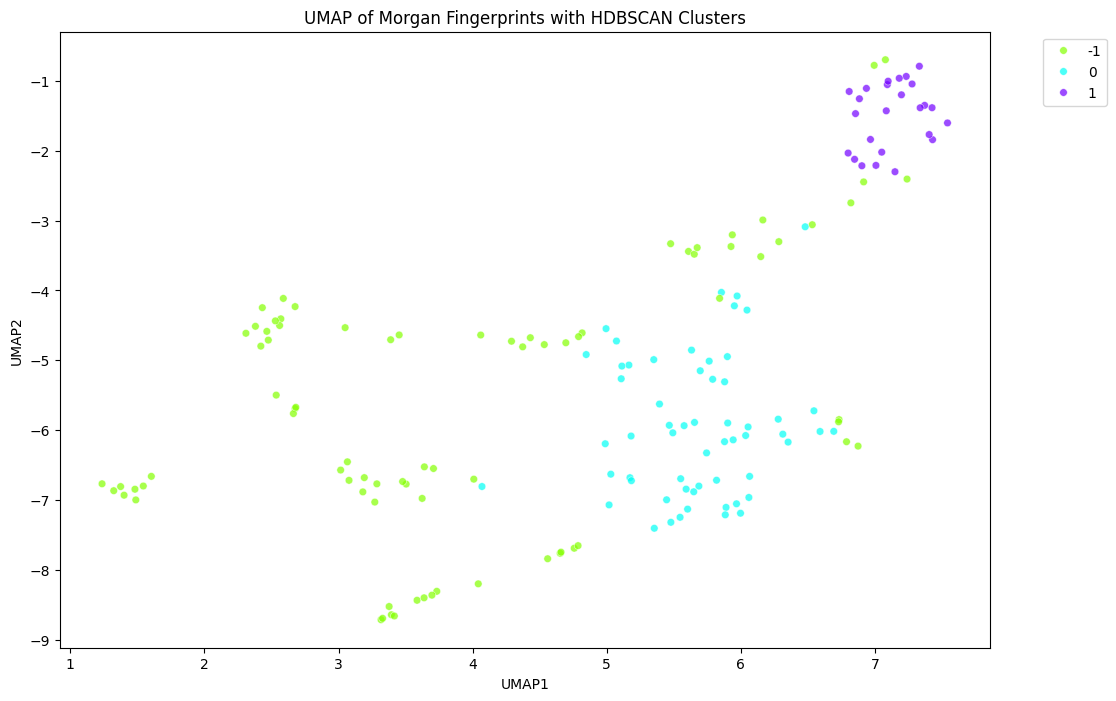

Number of outlier molecules: 82
                                           cleanedMol  \
2               Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cncc(Br)c1   
7                           CCCCCCC#Cc1cncc(C(=O)O)c1   
14  CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])cc...   
15  CCCCCCC#Cc1cncc(-c2nnc(SCCCn3ccc(=O)[nH]c3=O)n...   
17  CCCCCCC#Cc1cncc(-c2nnc(SC[C@H]3O[C@@H](n4ccc(=...   

                                             Scaffold  
2                   c1ccc(CSc2nnc(-c3cccnc3)[nH]2)cc1  
7                                            c1ccncc1  
14                  c1ccc(CSc2nnc(-c3cccnc3)[nH]2)cc1  
15       O=c1ccn(CCCSc2nnc(-c3cccnc3)[nH]2)c(=O)[nH]1  
17  O=c1ccn([C@@H]2O[C@H](CSc3nnc(-c4cccnc4)[nH]3)...  
Cluster 0: 58 molecules
Cluster 1: 25 molecules


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
import umap.umap_ as umap
import hdbscan
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 0. Check column exists
# -----------------------------
if 'cleanedMol' not in numeric_df.columns:
    raise ValueError("Column 'cleanedMol' not found in numeric_df")

# -----------------------------
# 1. Convert SMILES → Molecule safely
# -----------------------------
def safe_mol_from_smiles(smi):
    if isinstance(smi, str) and smi.strip():  # must be non-empty string
        mol = Chem.MolFromSmiles(smi)
        return mol
    return None

numeric_df['Molecule'] = numeric_df['cleanedMol'].apply(safe_mol_from_smiles)
numeric_df = numeric_df[numeric_df['Molecule'].notna()].reset_index(drop=True)
print(f"Valid molecules: {len(numeric_df)}")

# -----------------------------
# 2. Morgan Fingerprints (2048 bits, radius=2)
# -----------------------------
def calc_fp(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
    return np.array(fp, dtype=int)

numeric_df['Fingerprint'] = numeric_df['Molecule'].apply(calc_fp)
fingerprints = np.stack(numeric_df['Fingerprint'].values)

# -----------------------------
# 3. UMAP (2D)
# -----------------------------
umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.1,
    metric='jaccard',  # binary fingerprints
    random_state=42
)
umap_result = umap_model.fit_transform(fingerprints)
numeric_df['UMAP1'] = umap_result[:, 0]
numeric_df['UMAP2'] = umap_result[:, 1]

# -----------------------------
# 4. HDBSCAN tuning
# -----------------------------
best_clusters = None
best_score = -1
best_min_size = None
results = []

for min_size in [10, 20, 30, 50, 75, 100]:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_size, metric='euclidean')
    labels = clusterer.fit_predict(umap_result)

    # skip if no clusters
    if len(set(labels)) <= 1 or set(labels) == {-1}:
        continue

    mask = labels != -1
    if sum(mask) < 2:
        continue

    score = silhouette_score(umap_result[mask], labels[mask])
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    results.append((min_size, n_clusters, score))

    if score > best_score:
        best_score = score
        best_clusters = labels
        best_min_size = min_size

numeric_df['Cluster'] = best_clusters
print(f"Best HDBSCAN min_cluster_size: {best_min_size}, silhouette: {best_score:.3f}")

# Optional: show all tuning results
results_df = pd.DataFrame(results, columns=['min_size','n_clusters','silhouette_score'])
print(results_df.sort_values('silhouette_score', ascending=False))

# -----------------------------
# 5. Scaffold extraction
# -----------------------------
def get_scaffold_safe(mol):
    try:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    except:
        return None

numeric_df['Scaffold'] = numeric_df['Molecule'].apply(get_scaffold_safe)

# -----------------------------
# 6. Visualization
# -----------------------------
plt.figure(figsize=(12, 8))
unique_clusters = sorted(set(best_clusters))
palette = sns.color_palette("hsv", len(unique_clusters))

sns.scatterplot(
    x='UMAP1', y='UMAP2',
    hue='Cluster',
    data=numeric_df,
    palette=palette,
    s=30,
    alpha=0.7,
    legend='full'
)
plt.title("UMAP of Morgan Fingerprints with HDBSCAN Clusters")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

# -----------------------------
# 7. Outliers
# -----------------------------
outliers = numeric_df[numeric_df['Cluster'] == -1]
print(f"Number of outlier molecules: {len(outliers)}")
print(outliers[['cleanedMol', 'Scaffold']].head())

# -----------------------------
# 8. Cluster summary
# -----------------------------
for cluster_id in unique_clusters:
    if cluster_id == -1:
        continue
    cluster_size = sum(best_clusters == cluster_id)
    print(f"Cluster {cluster_id}: {cluster_size} molecules")


Valid molecules: 165


[21:16:18] DEPRECATION WARNING: please use MorganGenerator
[21:16:18] DEPRECATION WARNING: please use MorganGenerator
[21:16:18] DEPRECATION WARNING: please use MorganGenerator
[21:16:18] DEPRECATION WARNING: please use MorganGenerator
[21:16:18] DEPRECATION WARNING: please use MorganGenerator
[21:16:18] DEPRECATION WARNING: please use MorganGenerator
[21:16:18] DEPRECATION WARNING: please use MorganGenerator
[21:16:18] DEPRECATION WARNING: please use MorganGenerator
[21:16:18] DEPRECATION WARNING: please use MorganGenerator
[21:16:18] DEPRECATION WARNING: please use MorganGenerator
[21:16:18] DEPRECATION WARNING: please use MorganGenerator
[21:16:18] DEPRECATION WARNING: please use MorganGenerator
[21:16:18] DEPRECATION WARNING: please use MorganGenerator
[21:16:18] DEPRECATION WARNING: please use MorganGenerator
[21:16:18] DEPRECATION WARNING: please use MorganGenerator
[21:16:18] DEPRECATION WARNING: please use MorganGenerator
[21:16:18] DEPRECATION WARNING: please use MorganGenerat

Scaled fingerprint shape: (165, 1024)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Best HDBSCAN min_cluster_size: 10, silhouette: 0.611
   min_size  n_clusters  silhouette_score
0        10           3           0.61114


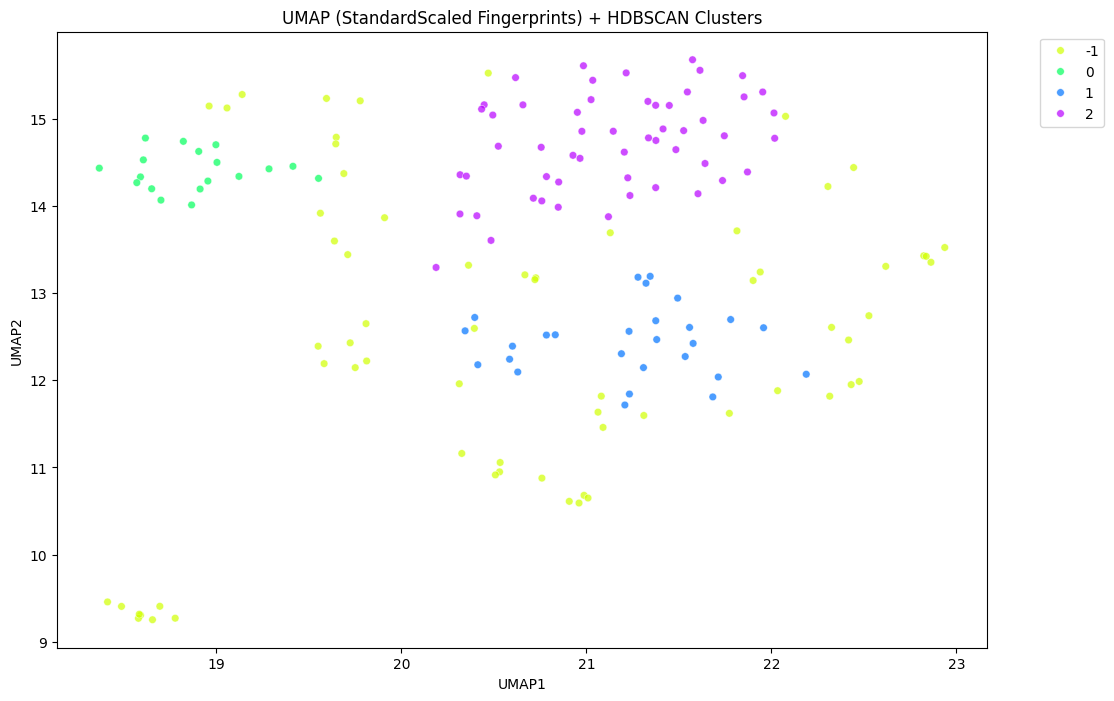

Number of outlier molecules: 66
                                           cleanedMol  \
10  CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(C(F)(F)F)cc3)n2...   
13       CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(OC)cc3)n2C)c1   
16        CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(O)cc3)n2C)c1   
17  CCCCCCC#Cc1cncc(-c2nnc(SC[C@H]3O[C@@H](n4ccc(=...   
36   CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C2CC2)c1   

                                             Scaffold  
10                  c1ccc(CSc2nnc(-c3cccnc3)[nH]2)cc1  
13                  c1ccc(CSc2nnc(-c3cccnc3)[nH]2)cc1  
16                  c1ccc(CSc2nnc(-c3cccnc3)[nH]2)cc1  
17  O=c1ccn([C@@H]2O[C@H](CSc3nnc(-c4cccnc4)[nH]3)...  
36                c1ccc(CSc2nnc(-c3cccnc3)n2C2CC2)cc1  
Cluster 0: 18 molecules
Cluster 1: 27 molecules
Cluster 2: 54 molecules


In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds import MurckoScaffold
import umap.umap_ as umap
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 0. Check column exists
# -----------------------------
if 'cleanedMol' not in numeric_df.columns:
    raise ValueError("Column 'cleanedMol' not found in numeric_df")

# -----------------------------
# 1. Convert SMILES → Molecule safely
# -----------------------------
def safe_mol_from_smiles(smi):
    if isinstance(smi, str) and smi.strip():
        mol = Chem.MolFromSmiles(smi)
        return mol
    return None

numeric_df['Molecule'] = numeric_df['cleanedMol'].apply(safe_mol_from_smiles)
numeric_df = numeric_df[numeric_df['Molecule'].notna()].reset_index(drop=True)
print(f"Valid molecules: {len(numeric_df)}")

# -----------------------------
# 2. Morgan Fingerprints (1024 bits)
# -----------------------------
def calc_fp(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024)
    return np.array(fp, dtype=float)  # floats needed for StandardScaler

numeric_df['Fingerprint'] = numeric_df['Molecule'].apply(calc_fp)
fingerprints = np.stack(numeric_df['Fingerprint'].values)

# -----------------------------
# 2B. Apply StandardScaler
# -----------------------------
scaler = StandardScaler()
fingerprints_scaled = scaler.fit_transform(fingerprints)
print("Scaled fingerprint shape:", fingerprints_scaled.shape)

# -----------------------------
# 3. UMAP (2D) with scaled features
# -----------------------------
umap_model = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.1,
    metric='euclidean',   # REQUIRED for scaled fingerprints
    random_state=42
)

umap_result = umap_model.fit_transform(fingerprints_scaled)
numeric_df['UMAP1'] = umap_result[:, 0]
numeric_df['UMAP2'] = umap_result[:, 1]

# -----------------------------
# 4. HDBSCAN tuning
# -----------------------------
best_clusters = None
best_score = -1
best_min_size = None
results = []

for min_size in [10, 20, 30, 50, 75, 100]:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_size, metric='euclidean')
    labels = clusterer.fit_predict(umap_result)

    # skip invalid runs
    if len(set(labels)) <= 1 or set(labels) == {-1}:
        continue

    mask = labels != -1
    if sum(mask) < 2:
        continue

    score = silhouette_score(umap_result[mask], labels[mask])
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    results.append((min_size, n_clusters, score))

    if score > best_score:
        best_score = score
        best_clusters = labels
        best_min_size = min_size

numeric_df['Cluster'] = best_clusters
print(f"Best HDBSCAN min_cluster_size: {best_min_size}, silhouette: {best_score:.3f}")

results_df = pd.DataFrame(results, columns=['min_size','n_clusters','silhouette_score'])
print(results_df.sort_values('silhouette_score', ascending=False))

# -----------------------------
# 5. Scaffold extraction
# -----------------------------
def get_scaffold_safe(mol):
    try:
        scaffold = MurckoScaffold.GetScaffoldForMol(mol)
        return Chem.MolToSmiles(scaffold)
    except:
        return None

numeric_df['Scaffold'] = numeric_df['Molecule'].apply(get_scaffold_safe)

# -----------------------------
# 6. Visualization
# -----------------------------
plt.figure(figsize=(12, 8))
unique_clusters = sorted(set(best_clusters))
palette = sns.color_palette("hsv", len(unique_clusters))

sns.scatterplot(
    x='UMAP1', y='UMAP2',
    hue='Cluster',
    data=numeric_df,
    palette=palette,
    s=30,
    alpha=0.7,
    legend='full'
)

plt.title("UMAP (StandardScaled Fingerprints) + HDBSCAN Clusters")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

# -----------------------------
# 7. Outliers
# -----------------------------
outliers = numeric_df[numeric_df['Cluster'] == -1]
print(f"Number of outlier molecules: {len(outliers)}")
print(outliers[['cleanedMol', 'Scaffold']].head())

# -----------------------------
# 8. Cluster summary
# -----------------------------
for cluster_id in unique_clusters:
    if cluster_id == -1:
        continue
    cluster_size = sum(best_clusters == cluster_id)
    print(f"Cluster {cluster_id}: {cluster_size} molecules")


In [ ]:
numeric_df['transformed_IC50'] = np.log10(numeric_df['IC50 uM'] + 1e-8)

In [ ]:
# Initialize scaffold splitter
splitter = ScaffoldSplitter(smiles_col='Canonical SMILES')

# Perform scaffold-based split
train_idx, val_idx, test_idx = splitter.scaffold_split(
    numeric_df,
    test_size=0.2,
    val_size=0.1,
    random_state=42
)

# Remove near-duplicates
print("\n🔍 Checking for near-duplicates...")
train_idx, test_idx = processor.remove_near_duplicates(
    numeric_df, train_idx, test_idx, threshold=0.95
)

# Analyze similarity
print("\n📊 Analyzing Train-Test Similarity...")
similarity_stats = processor.analyze_similarity(numeric_df, train_idx, test_idx)
plot_similarity_distribution(similarity_stats, save_path='model4_similarity.png')

# Create split dataframes
train_df_clean = numeric_df.iloc[train_idx].reset_index(drop=True)
val_df_clean = numeric_df.iloc[val_idx].reset_index(drop=True)
test_df_clean = numeric_df.iloc[test_idx].reset_index(drop=True)

# Verification
print("\n" + "="*70)
print("🔍 VERIFICATION: Checking for Data Leakage")
print("="*70)

train_smiles = set(train_df_clean['Canonical SMILES'])
val_smiles = set(val_df_clean['Canonical SMILES'])
test_smiles = set(test_df_clean['Canonical SMILES'])

overlap_train_test = train_smiles & test_smiles
overlap_train_val = train_smiles & val_smiles
overlap_val_test = val_smiles & test_smiles

if not any([overlap_train_test, overlap_train_val, overlap_val_test]):
    print("\n🎉 ALL CHECKS PASSED - No data leakage detected!")
    print(f"\n   Train: {len(train_df_clean)} | Val: {len(val_df_clean)} | Test: {len(test_df_clean)}")
else:
    print("\n⚠️  WARNING: DATA LEAKAGE DETECTED!")
print("="*70)

# Update df2 for model training (use training set only)
df2 = train_df_clean.copy()
df_validation = val_df_clean.copy()
df_test = test_df_clean.copy()

print("\n✅ Data prepared for Gaussian Process:")
print("   df2 (training): Use for GP training")
print("   df_validation: Use for hyperparameter tuning")
print("   df_test: Use for final evaluation")
print("\n⚠️  Generate fingerprints SEPARATELY for each split!")
print("   Use scaffold-based CV for Bayesian optimization!")
print("   Scale features: FIT on df2, TRANSFORM df_validation and df_test")

## 🔬 Scaffold-Based Data Splitting (Prevents Leakage!)

**⚠️ CRITICAL CHANGE:** Replacing random K-Fold with scaffold-based splitting

**Why this matters for Gaussian Process models:**
- Random splitting → Similar molecules in train/test → **Inflated performance!**
- Scaffold splitting → Entire scaffolds in train OR test → **Realistic estimates!**
- Bayesian optimization should use scaffold-based CV → **No hyperparameter leakage!**

**Important for GP + Bayesian Optimization:**
- Split data FIRST using scaffolds
- Generate fingerprints per split
- Tune GP hyperparameters using scaffold-based CV
- Scale features (fit on train only!)

In [ ]:
# Import validation utilities
from qsar_validation_utils import (
    DatasetBiasAnalyzer, ActivityCliffDetector, ModelComplexityAnalyzer,
    PerformanceMetricsCalculator, YRandomizationTester, AssayNoiseEstimator
)

print("=" * 80)
print("COMPREHENSIVE VALIDATION - MODEL 4 (GP + BAYESIAN OPTIMIZATION)")
print("=" * 80)

# Initialize analyzer
analyzer = DatasetBiasAnalyzer(smiles_col='Canonical SMILES', target_col='IC50 uM')

# 1. Scaffold diversity analysis
diversity_results = analyzer.analyze_scaffold_diversity(df)
activity_stats = analyzer.analyze_activity_distribution(df)

# Report split diversity
analyzer.report_split_diversity(
    diversity_results['df_with_scaffolds'], train_idx, val_idx, test_idx
)

# 2. Model complexity - Gaussian Process with 1024-bit fingerprints
print("\n" + "=" * 80)
print("MODEL COMPLEXITY ANALYSIS (Gaussian Process)")
print("=" * 80)
print("📌 Gaussian Processes work well with small datasets!")
ModelComplexityAnalyzer.analyze_complexity(
    n_samples=len(df2),
    n_features=1024,
    model_type='gaussian_process'
)

# 3. Activity cliff detection
cliff_detector = ActivityCliffDetector(smiles_col='Canonical SMILES', target_col='IC50 uM')
cliff_df = cliff_detector.detect_activity_cliffs(df2, similarity_threshold=0.85, activity_threshold=2.0)

if len(cliff_df) > 0:
    print(f"\n✓ GOOD NEWS: GP can handle {len(cliff_df)} activity cliffs better than other methods")
    print("  → GP kernel can capture non-smooth relationships")
    print("  → Use uncertainty estimates to flag unreliable predictions")

# 4. Assay noise estimation
noise_estimator = AssayNoiseEstimator()
error_estimate = noise_estimator.estimate_experimental_error(df, 'IC50 uM')

print("\n" + "=" * 80)
print("✓ VALIDATION SUMMARY")
print("=" * 80)
print(f"\n📊 DATASET:")
print(f"   • Molecules: {len(df)} → Train: {len(df2)}, Val: {len(df3)}, Test: {len(df4)}")
print(f"   • Scaffolds: {diversity_results['n_scaffolds']} (diversity: {diversity_results['diversity_ratio']:.3f})")
print(f"   • Activity range: [{activity_stats['min']:.2f}, {activity_stats['max']:.2f}]")
print(f"   • Activity cliffs: {len(cliff_df)} pairs")
print(f"\n📊 MODEL:")
print(f"   • Type: Gaussian Process (good for n < 500)")
print(f"   • Features: 1024 circular fingerprint bits")
print(f"   • Samples:Features: {len(df2)/1024:.2f}:1")
print(f"   • Built-in uncertainty: YES ✓")
print(f"\n⚠️ PERFORMANCE TARGET:")
print(f"   • Assay noise: ~{error_estimate['experimental_error']:.1f} log units")
print(f"   • Target RMSE: ~{error_estimate['experimental_error']:.1f} (near-optimal)")
print(f"   • Use GP uncertainty for applicability domain!")
print(f"\n📌 NEXT: Generate fingerprints PER SPLIT with proper scaling")

## 📊 COMPREHENSIVE VALIDATION ANALYSIS

**Validation for Gaussian Process + Bayesian Optimization:**

1. Dataset bias & representativeness
2. Model complexity (1024 fingerprint bits)
3. Activity cliffs & SAR discontinuities
4. Assay noise (~0.5 log units IC50)
5. Uncertainty quantification (GP strength!)
6. Baseline comparison
7. Y-randomization test

📌 **GP Advantage**: Built-in uncertainty estimates - use them for applicability domain!

## Baseline-Model

### Rdkit

In [ ]:
df=numeric_df

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, rdMolDescriptors
from rdkit import DataStructs

# Function to calculate circular (Morgan) fingerprint using latest RDKit features
def calculate_circular_fingerprint(smiles, radius=2, nBits=1024):
    # Convert SMILES to RDKit molecule with sanitization
    mol = Chem.MolFromSmiles(smiles, sanitize=True)
    if mol is None:
        return np.full(nBits, np.nan, dtype=int)

    # Calculate Morgan fingerprint as bit vector
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)

    # Convert to numpy array
    arr = np.zeros((nBits,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Apply to DataFrame (assuming 'cleanedMol' column contains SMILES)
fingerprint_array = np.vstack(df['cleanedMol'].apply(lambda x: calculate_circular_fingerprint(x, radius=2, nBits=1024)))

# Convert array to DataFrame
fp_df = pd.DataFrame(fingerprint_array, columns=[f'FP_{i}' for i in range(fingerprint_array.shape[1])])

# Merge with original DataFrame
df = pd.concat([df.reset_index(drop=True), fp_df.reset_index(drop=True)], axis=1)


[21:16:20] DEPRECATION WARNING: please use MorganGenerator
[21:16:20] DEPRECATION WARNING: please use MorganGenerator
[21:16:20] DEPRECATION WARNING: please use MorganGenerator
[21:16:20] DEPRECATION WARNING: please use MorganGenerator
[21:16:20] DEPRECATION WARNING: please use MorganGenerator
[21:16:20] DEPRECATION WARNING: please use MorganGenerator
[21:16:20] DEPRECATION WARNING: please use MorganGenerator
[21:16:20] DEPRECATION WARNING: please use MorganGenerator
[21:16:20] DEPRECATION WARNING: please use MorganGenerator
[21:16:20] DEPRECATION WARNING: please use MorganGenerator
[21:16:20] DEPRECATION WARNING: please use MorganGenerator
[21:16:20] DEPRECATION WARNING: please use MorganGenerator
[21:16:20] DEPRECATION WARNING: please use MorganGenerator
[21:16:20] DEPRECATION WARNING: please use MorganGenerator
[21:16:20] DEPRECATION WARNING: please use MorganGenerator
[21:16:20] DEPRECATION WARNING: please use MorganGenerator
[21:16:20] DEPRECATION WARNING: please use MorganGenerat

In [ ]:
df

,Identifier,Canonical SMILES,IC50 uM,PIC50,valid_smiles,cleanedMol,Molecule,Fingerprint,UMAP1,UMAP2,...,FP_1014,FP_1015,FP_1016,FP_1017,FP_1018,FP_1019,FP_1020,FP_1021,FP_1022,FP_1023
0,TB-VS0012,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N2C)=...,5.300,5.275724,True,CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1,<rdkit.Chem.rdchem.Mol object at 0x7b91e0330430>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",21.375677,14.751518,...,0,0,0,0,0,0,0,0,0,0
1,TB-VS12-2,BrC1=CC(C2=NN=C(N2C)S)=CN=C1,200.000,3.698970,True,Cn1c(-c2cncc(Br)c2)n[nH]c1=S,<rdkit.Chem.rdchem.Mol object at 0x7b91e0331770>,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",21.322189,13.113513,...,0,0,0,0,0,0,0,0,0,0
2,TB-VS12-3,BrC1=CC(C2=NN=C(N2C)SCC3=CC=C(C=C3)Cl)=CN=C1,200.000,3.698970,True,Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cncc(Br)c1,<rdkit.Chem.rdchem.Mol object at 0x7b91e0331460>,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...",20.493898,15.043191,...,0,0,0,0,0,0,0,0,0,0
3,TB-VS12-4,CCCCCCC#CC1=CC(C2=NN=C(N2C)S)=CN=C1,22.570,4.646468,True,CCCCCCC#Cc1cncc(-c2n[nH]c(=S)n2C)c1,<rdkit.Chem.rdchem.Mol object at 0x7b91e03315b0>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",21.278896,13.182528,...,0,0,0,0,0,0,0,0,0,0
4,TB-VS12-5,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=CC=C3)N2C)=CN=C1,175.000,3.756962,True,CCCCCCC#Cc1cncc(-c2nnc(SCc3ccccc3)n2C)c1,<rdkit.Chem.rdchem.Mol object at 0x7b91e03314d0>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",20.927437,14.580971,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,ROY-0000175-001,CC(OC(N(C1)CC21CCN(C3=CC(C#CC4=CC=CC=C4)=CN=C3...,6.843,5.164753,True,CC(C)(C)OC(=O)N1CC2(CCN(c3cncc(C#Cc4ccccc4)c3)...,<rdkit.Chem.rdchem.Mol object at 0x7b91e0301cb0>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20.469419,15.524208,...,0,0,0,0,0,0,0,0,0,0
161,ROY-0000223-001,ClC(C=C1)=CC=C1CO[C@H](CC2)CN2C3=CC(C#CC4=CC=C...,5.615,5.250650,True,FC(F)(F)Oc1ccc(C#Cc2cncc(N3CC[C@@H](OCc4ccc(Cl...,<rdkit.Chem.rdchem.Mol object at 0x7b91e0301f50>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22.862667,13.353951,...,0,0,0,0,1,1,0,0,0,0
162,ROY-0000222-001,ClC(C=C1)=CC=C1CO[C@H](CC2)CN2C3=CC(C#CC4=CC=C...,9.705,5.013004,True,Clc1ccc(CO[C@@H]2CCN(c3cncc(C#Cc4ccccc4)c3)C2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7b91e0301e70>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22.837101,13.422137,...,0,0,0,0,1,1,0,0,0,0
163,ROY-0000225-001,CC(OC(N1CC(OCCCC2=CC=CC=C2)C1)=O)(C)C,148.000,3.829738,True,CC(C)(C)OC(=O)N1CC(OCCCc2ccccc2)C1,<rdkit.Chem.rdchem.Mol object at 0x7b91e0302110>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20.433498,15.111303,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
feature1=df.iloc[:, 16:]

In [ ]:
df

,Identifier,Canonical SMILES,IC50 uM,PIC50,valid_smiles,cleanedMol,Molecule,Fingerprint,UMAP1,UMAP2,...,FP_1014,FP_1015,FP_1016,FP_1017,FP_1018,FP_1019,FP_1020,FP_1021,FP_1022,FP_1023
0,TB-VS0012,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N2C)=...,5.300,5.275724,True,CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1,<rdkit.Chem.rdchem.Mol object at 0x7b91e0330430>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",21.375677,14.751518,...,0,0,0,0,0,0,0,0,0,0
1,TB-VS12-2,BrC1=CC(C2=NN=C(N2C)S)=CN=C1,200.000,3.698970,True,Cn1c(-c2cncc(Br)c2)n[nH]c1=S,<rdkit.Chem.rdchem.Mol object at 0x7b91e0331770>,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",21.322189,13.113513,...,0,0,0,0,0,0,0,0,0,0
2,TB-VS12-3,BrC1=CC(C2=NN=C(N2C)SCC3=CC=C(C=C3)Cl)=CN=C1,200.000,3.698970,True,Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cncc(Br)c1,<rdkit.Chem.rdchem.Mol object at 0x7b91e0331460>,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...",20.493898,15.043191,...,0,0,0,0,0,0,0,0,0,0
3,TB-VS12-4,CCCCCCC#CC1=CC(C2=NN=C(N2C)S)=CN=C1,22.570,4.646468,True,CCCCCCC#Cc1cncc(-c2n[nH]c(=S)n2C)c1,<rdkit.Chem.rdchem.Mol object at 0x7b91e03315b0>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",21.278896,13.182528,...,0,0,0,0,0,0,0,0,0,0
4,TB-VS12-5,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=CC=C3)N2C)=CN=C1,175.000,3.756962,True,CCCCCCC#Cc1cncc(-c2nnc(SCc3ccccc3)n2C)c1,<rdkit.Chem.rdchem.Mol object at 0x7b91e03314d0>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",20.927437,14.580971,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,ROY-0000175-001,CC(OC(N(C1)CC21CCN(C3=CC(C#CC4=CC=CC=C4)=CN=C3...,6.843,5.164753,True,CC(C)(C)OC(=O)N1CC2(CCN(c3cncc(C#Cc4ccccc4)c3)...,<rdkit.Chem.rdchem.Mol object at 0x7b91e0301cb0>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20.469419,15.524208,...,0,0,0,0,0,0,0,0,0,0
161,ROY-0000223-001,ClC(C=C1)=CC=C1CO[C@H](CC2)CN2C3=CC(C#CC4=CC=C...,5.615,5.250650,True,FC(F)(F)Oc1ccc(C#Cc2cncc(N3CC[C@@H](OCc4ccc(Cl...,<rdkit.Chem.rdchem.Mol object at 0x7b91e0301f50>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22.862667,13.353951,...,0,0,0,0,1,1,0,0,0,0
162,ROY-0000222-001,ClC(C=C1)=CC=C1CO[C@H](CC2)CN2C3=CC(C#CC4=CC=C...,9.705,5.013004,True,Clc1ccc(CO[C@@H]2CCN(c3cncc(C#Cc4ccccc4)c3)C2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7b91e0301e70>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22.837101,13.422137,...,0,0,0,0,1,1,0,0,0,0
163,ROY-0000225-001,CC(OC(N1CC(OCCCC2=CC=CC=C2)C1)=O)(C)C,148.000,3.829738,True,CC(C)(C)OC(=O)N1CC(OCCCc2ccccc2)C1,<rdkit.Chem.rdchem.Mol object at 0x7b91e0302110>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20.433498,15.111303,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
target=df['transformed_IC50']
target.head()

,transformed_IC50
0,0.724276
1,2.301030
2,2.301030
3,1.353532
4,2.243038


In [ ]:
# Install H2O if not already installed
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.0/266.0 MB 3.8 MB/s eta 0:00:00


In [ ]:
!pip install scikit-optimize


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.8 MB/s eta 0:00:00


# Gausian process with bayesian optimization

# Gausian process with bayesian optimization - Chemistry aware - optuna optimization

🔎 Running Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 18.6633
Function value obtained: 0.6593
Current minimum: 0.6593
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 14.5950
Function value obtained: 0.6594
Current minimum: 0.6593
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 21.9567
Function value obtained: 0.6594
Current minimum: 0.6593
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 22.9508
Function value obtained: 0.6593
Current minimum: 0.6593
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 15.4126
Function value obtained: 0.6594
Curr

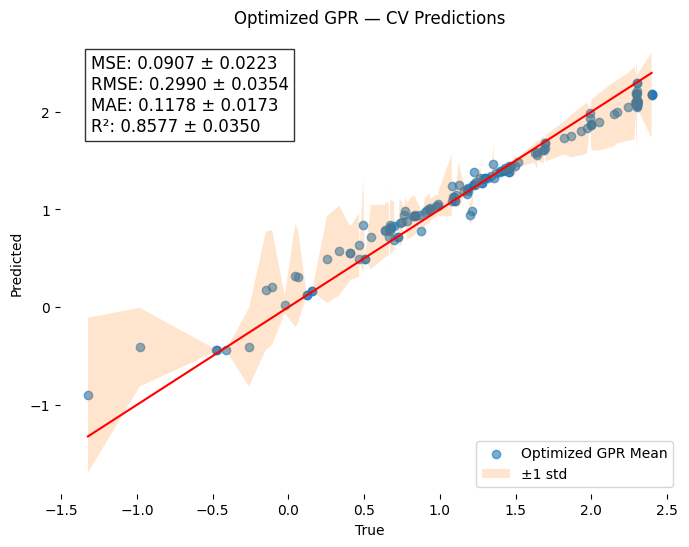


Final optimized GPR model trained on full dataset.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# -----------------------------
# 1️⃣ Standard Scaling
# -----------------------------
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(feature1),
    columns=feature1.columns,
    index=feature1.index
)

df2 = pd.concat([X_scaled, target], axis=1)
X = X_scaled.values
y = target.values

# -----------------------------
# 2️⃣ Hyperparameter Search Space
# -----------------------------
search_space = [
    Real(1e-3, 10.0,    name="kernel_scale"),   # amplitude of kernel
    Real(1e-3, 10.0,    name="length_scale"),   # RBF length scale
    Real(1e-8, 1e-2,    name="alpha"),          # noise term
    Integer(1, 10,      name="n_restarts")      # optimizer restarts
]

K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)

# -----------------------------
# 3️⃣ Objective: Minimize CV RMSE
# -----------------------------
@use_named_args(search_space)
def objective(kernel_scale, length_scale, alpha, n_restarts):

    fold_rmses = []

    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        kernel = C(kernel_scale) * RBF(length_scale)
        gpr = GaussianProcessRegressor(
            kernel=kernel,
            alpha=alpha,
            normalize_y=True,
            n_restarts_optimizer=n_restarts,
            random_state=42
        )

        gpr.fit(X_train, y_train)

        preds = gpr.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, preds))
        fold_rmses.append(rmse)

    return np.mean(fold_rmses)

# -----------------------------
# 4️⃣ Run Bayesian Optimization
# -----------------------------
print("🔎 Running Bayesian hyperparameter optimization...")
result = gp_minimize(
    objective,
    search_space,
    n_calls=40,            # number of evaluations
    random_state=42,
    verbose=True
)

best_kernel_scale, best_length_scale, best_alpha, best_n_restarts = result.x
print("\nBest hyperparameters found:")
print(f"  kernel_scale = {best_kernel_scale}")
print(f"  length_scale = {best_length_scale}")
print(f"  alpha        = {best_alpha}")
print(f"  n_restarts   = {best_n_restarts}")

# -----------------------------
# 5️⃣ Build Optimized Kernel
# -----------------------------
best_kernel = C(best_kernel_scale) * RBF(best_length_scale)

# -----------------------------
# 6️⃣ K-Fold CV Using Optimized GPR
# -----------------------------
cv_preds_all = []

for fold, (train_idx, valid_idx) in enumerate(kf.split(df2), 1):
    print(f"Training fold {fold}/{K} with optimized GPR...")

    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train = y[train_idx]

    gpr = GaussianProcessRegressor(
        kernel=best_kernel,
        alpha=best_alpha,
        normalize_y=True,
        n_restarts_optimizer=best_n_restarts,
        random_state=42
    )

    gpr.fit(X_train, y_train)

    # Predict on entire dataset for aggregated mean/std
    preds = gpr.predict(X)
    cv_preds_all.append(preds)

cv_preds_all = np.array(cv_preds_all).T  # (n_samples, n_folds)

y_pred_mean = cv_preds_all.mean(axis=1)
y_pred_std = cv_preds_all.std(axis=1)
y_true = y.copy()

# -----------------------------
# 7️⃣ Metrics
# -----------------------------
fold_metrics = []
for fold_preds in cv_preds_all.T:
    fold_mse = mean_squared_error(y_true, fold_preds)
    fold_rmse = np.sqrt(fold_mse)
    fold_mae = mean_absolute_error(y_true, fold_preds)
    fold_r2 = r2_score(y_true, fold_preds)
    fold_metrics.append([fold_mse, fold_rmse, fold_mae, fold_r2])

fold_metrics = np.array(fold_metrics)
mse_mean, rmse_mean, mae_mean, r2_mean = fold_metrics.mean(axis=0)
mse_std, rmse_std, mae_std, r2_std = fold_metrics.std(axis=0)

metrics_text = (
    f"MSE: {mse_mean:.4f} ± {mse_std:.4f}\n"
    f"RMSE: {rmse_mean:.4f} ± {rmse_std:.4f}\n"
    f"MAE: {mae_mean:.4f} ± {mae_std:.4f}\n"
    f"R²: {r2_mean:.4f} ± {r2_std:.4f}"
)

print("\nCross-validation metrics (optimized GPR):")
print(metrics_text)

# -----------------------------
# 8️⃣ Smooth Plot
# -----------------------------
sorted_idx = np.argsort(y_true)
plt.figure(figsize=(8, 6))
plt.scatter(
    y_true[sorted_idx], y_pred_mean[sorted_idx],
    alpha=0.6, label='Optimized GPR Mean'
)
plt.fill_between(
    y_true[sorted_idx],
    y_pred_mean[sorted_idx] - y_pred_std[sorted_idx],
    y_pred_mean[sorted_idx] + y_pred_std[sorted_idx],
    alpha=0.2, label='±1 std'
)
plt.plot(y_true[sorted_idx], y_true[sorted_idx], color='red')
plt.title("Optimized GPR — CV Predictions")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         fontsize=12, va='top', bbox=dict(facecolor='white', alpha=0.8))
plt.legend()
plt.grid(False)
plt.box(False)
plt.show()

# -----------------------------
# 9️⃣ Final GPR on Full Data
# -----------------------------
final_gpr = GaussianProcessRegressor(
    kernel=best_kernel,
    alpha=best_alpha,
    normalize_y=True,
    n_restarts_optimizer=best_n_restarts,
    random_state=42
)

final_gpr.fit(X, y)
print("\nFinal optimized GPR model trained on full dataset.")


In [ ]:
# -----------------------------
# Complete prediction pipeline for new SMILES using GPR features
# -----------------------------
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 0️⃣ Standardize SMILES (if needed)
# -----------------------------
numeric_df['cleanedMol'] = numeric_df['Canonical SMILES'].apply(standardize_smiles, verbose=True)

# -----------------------------
# 1️⃣ Example new SMILES
# -----------------------------
smiles_list = [
    'CCCCCCC#CC1=CN=CC(N2CCC3(CN(C(C4=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C4)=O)C3)C2)=C1',
]

# -----------------------------
# 2️⃣ Function to calculate circular (Morgan) fingerprints
# -----------------------------
def calculate_circular_fingerprint(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.full(nBits, np.nan)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    arr = np.zeros((nBits,), dtype=int)
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# -----------------------------
# 3️⃣ Convert SMILES to fingerprint DataFrame
# -----------------------------
fingerprint_array = np.array([
    calculate_circular_fingerprint(smi, radius=2, nBits=1024)
    for smi in smiles_list
])

new_data = pd.DataFrame(
    fingerprint_array,
    columns=[f'FP_{i}' for i in range(fingerprint_array.shape[1])]
)

# -----------------------------
# 4️⃣ Ensure columns match training features
# -----------------------------
x_cols = list(feature1.columns)  # use columns from the training data
new_data = new_data[x_cols]      # reorder

# -----------------------------
# 5️⃣ Apply the same StandardScaler used for training
# -----------------------------
# Use the scaler fitted on training data
new_data_scaled_array = scaler.fit_transform(new_data)
new_data_scaled = pd.DataFrame(new_data_scaled_array, columns=x_cols)


# -----------------------------
# 6️⃣ Predict using trained GPR
# -----------------------------
preds = final_gpr.predict(new_data_scaled.values)

# -----------------------------
# 7️⃣ Convert back from log10 to original scale if your target was log-transformed
# -----------------------------
preds_original = 10 ** preds

# -----------------------------
# 8️⃣ Collect predictions
# -----------------------------
preds_final = pd.DataFrame({
    'SMILES': smiles_list,
    'Predicted_original_scale': preds_original
})

print("Predictions on original scale:")
print(preds_final)


Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1
Original: BrC1=CC(C2=NN=C(N2C)S)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
Cn1c(-c2cncc(Br)c2)n[nH]c1=S
Original: BrC1=CC(C2=NN=C(N2C)SCC3=CC=C(C=C3)Cl)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cncc(Br)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(N2C)S)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2n[nH]c(=S)n2C)c1
Original: CCCCCCC#

[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Normalizer
[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Normalizer
[21:24:21] Running LargestFragmentChooser
[21:24:21] Running Uncharger
[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Normalizer
[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Normalizer
[21:24:21] Running LargestFragmentChooser
[21:24:21] Running Uncharger
[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Normalizer
[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Norma

Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(C)cc3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(OC)C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(OC)cc3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C([N+]([O-])=O)C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])cc3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(N2C)SCCCN3C(NC(C=C3)=O)=O)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCCCn3ccc(=O)[nH]c3=O)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(O)C=C3)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the

[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Normalizer
[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Normalizer
[21:24:21] Running LargestFragmentChooser
[21:24:21] Running Uncharger
[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Normalizer
[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Normalizer
[21:24:21] Running LargestFragmentChooser
[21:24:21] Running Uncharger
[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Normalizer
[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Norma

Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(O)cc3)n2CCCN)c1
Original: ClC(C=C1)=CC=C1CSC(N2C3=CC=CC=C3)=NN=C2C4=CN=CC(C#CCCCCCC)=C4
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2-c2ccccc2)c1
Original: ClC1=CC=C(CSC2=NN=C(C3=CN=CC=C3)N2C)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cccnc1
Original: CN1C(SCC2=CC(F)=CC(F)=C2)=NN=C1C3=CN=CC(C#CCCCCCC)=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc(F)cc(F)c3)n2C)c1
Original: CN1C(SCC2=CC=C(Cl)C(F)=C2)=NN=C1C3=CN=CC(C#CCCCCCC)=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the 

[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Normalizer
[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Normalizer
[21:24:21] Running LargestFragmentChooser
[21:24:21] Running Uncharger
[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Normalizer
[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Normalizer
[21:24:21] Running LargestFragmentChooser
[21:24:21] Running Uncharger
[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Normalizer
[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Norma

Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc(=O)[nH]c(=O)[nH]3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C3)N2CCC[NH3+])=CN=C1.[Cl-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2CCCN)c1
Original: CN1C(C2=CC=CC(C#CCCCCCC)=C2)=NN=C1SCC3=CC=C(Cl)C=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cccc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1
Original: CN1C(C2=CN=CC(C#CCCCCCC)=C2)=NN=C1SCC3=CC=C(Cl)C=C3[N+]([O-])=O
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3[N+](=O)[O-])n2C)c1
Original: CN1C(C2=CN=CC(C#C)=C2)=NN=C1SC

[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Normalizer
[21:24:21] Initializing MetalDisconnector
[21:24:21] Running MetalDisconnector
[21:24:21] Initializing Normalizer
[21:24:21] Running Normalizer
[21:24:21] Running LargestFragmentChooser
[21:24:21] Fragment: CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2CCC[NH3+])c1
[21:24:21] New largest fragment: CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2CCC[NH3+])c1 (67)
[21:24:21] Fragment: [Cl-]
[21:24:21] Running Uncharger
[21:24:21] Removed positive charge.
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Running LargestFragmentChooser
[21:24:22] Running Uncharger
[21:24

Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(Sc3ccc([N+](=O)[O-])cc3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SC3=CC=C([N+]([O-])=O)C=C3[N+]([O-])=O)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(Sc3ccc([N+](=O)[O-])cc3[N+](=O)[O-])n2C)c1
Original: CCCCCCC#CC1=CC(NC(SCC2=CC=C(Cl)C=C2)=O)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(NC(=O)SCc2ccc(Cl)cc2)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SC)N2C)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc

[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Running LargestFragmentChooser
[21:24:22] Running Uncharger
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Running LargestFragmentChooser
[21:24:22] Running Uncharger
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Running LargestFragmentChooser
[21:24:22] Running Uncharger
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalD

Original: CN1C(C2=CN=CC(C#CC3(CC4C5)CC(C4)CC5C3)=C2)=NN=C1SCC6=CC=C(Cl)C=C6
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cncc(C#CC23CC4CC(CC(C4)C2)C3)c1
Original: ClC1=CC=C(C=C1)CSC2=NN=C(N2C)C3=CC(C#CCCCCCC)=C[NH+]=C3.[Cl-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1
Original: CN1C(SCCC2=CC=C(Cl)C=C2)=NN=C1C3=CC(C#CCCCCCC)=CN=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCCc3ccc(Cl)cc3)n2C)c1
Original: CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)S2)=CN=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fr

[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Running LargestFragmentChooser
[21:24:22] Running Uncharger
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Running LargestFragmentChooser
[21:24:22] Fragment: CCCCCCC#Cc1c[nH+]cc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1
[21:24:22] New largest fragment: CCCCCCC#Cc1c[nH+]cc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1 (55)
[21:24:22] Fragment: [Cl-]
[21:24:22] Running Uncharger
[21:24:22] Removed positive charge.
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running M

Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(N2CC(OCc3ccc(Cl)cc3)C2)c1
Original: ClC1=CC=C(CO[C@H](CC2)CN2C3=CC(C#CCCCCCC)=CN=C3)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(N2CC[C@@H](OCc3ccc(Cl)cc3)C2)c1
Original: ClC1=CC=C(CO[C@@H](CC2)CN2C3=CC(C#CCCCCCC)=CN=C3)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(N2CC[C@H](OCc3ccc(Cl)cc3)C2)c1
Original: CCCCCCC#CC1=CN=CC(C2=NN(CC3=CC=C(Cl)C=C3)C(O2)=O)=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nn(Cc3ccc(Cl)cc3)c(=O)o2)c1
Original: CCCCCCCC#CC1=CN=CC(C(N2C3CC3)=NN=C2SCC4=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C4)=C1
Remove Hs, disc

[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Running LargestFragmentChooser
[21:24:22] Running Uncharger
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Running LargestFragmentChooser
[21:24:22] Running Uncharger
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Norma

Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCOc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1
Original: OCCN1C(C2=CC(C#CCCCCCCC)=CN=C2)=NN=C1SCC3=CC=C(Cl)C=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2CCO)c1
Original: OCCN1C(C2=CC(C#CCCCCCCC)=CN=C2)=NN=C1SCC3=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C3
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2CCO)c1
Original: O=C(O)C(F)(F)F.S=C1N(C[C@H]2O[C@H]([C@@H]([C@@H]2O)O)N3C=CC(NC3=O)=O)N=C(N1CCCN)C4=CC(C#CCCCCCC)=CN=C4
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "paren

[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Running LargestFragmentChooser
[21:24:22] Running Uncharger
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Running LargestFragmentChooser
[21:24:22] Running Uncharger
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Normalizer
[21:24:22] Initializing MetalDisconnector
[21:24:22] Running MetalDisconnector
[21:24:22] Initializing Normalizer
[21:24:22] Running Norma

Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cncc(Br)c3)n2C)c1
Original: CCCCCCC#CC1=CN=CC(C(N2CCCN)=NN=C2SCC3=CC=C([N+](=O)[O-])O3)=C1.Cl.Cl
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])o3)n2CCCN)c1
Original: CCCCCCC#CC1=CN=CC(C(N2CCO)=NN=C2SCC3=CC=C([N+]([O-])=O)O3)=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])o3)n2CCO)c1
Original: CCCCCCC#CC1=CN=CC(N2C[C@@H](CC2)NC(C3=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C3)=O)=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(N2CC[C@@H](NC(=O)c3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)C2)c1
Original: NCCCN1C(SCC2=CC([N

[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Running LargestFragmentChooser
[21:24:23] Running Uncharger
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Running LargestFragmentChooser
[21:24:23] Running Uncharger
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Norma

Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)Nc1nc2ccccc2[nH]1
Original: COC1=CC=C(CSC[C@H](N)C(NC2=CC(C#CCCCCCC)=CN=C2)=O)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(NC(=O)C(N)CSCc2ccc(OC)cc2)c1
Original: N[C@H](C(NC1=CC(C#CCCCCCC)=CN=C1)=O)CSCC2=CC=C(C=C2)Cl
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(NC(=O)C(N)CSCc2ccc(Cl)cc2)c1
Original: N[C@@H](CSCC1=CC=C(C=C1)Cl)C(NC2=CC=C(C(F)=C2)F)=O
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)Nc1ccc(F)c(F)c1
Original: O=C(NC12CC3CC4CC(C342)C1)[C@@H](N)CSCC5=CC=C(Cl)C=C5
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecul

[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Running LargestFragmentChooser
[21:24:23] Running Uncharger
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Running LargestFragmentChooser
[21:24:23] Running Uncharger
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Running LargestFragmentChooser
[21:24:23] Running Uncharger
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normal

Enumerate tautomers:
CCCCCCC#Cc1cncc(NC(=O)C(N)Cc2cc3ccccc3[nH]2)c1
Original: N[C@@H](CSCC1=CC=C(Cl)C=C1)C(NC2=C3C=CC=CC3=CC=C2)=O
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)Nc1cccc2ccccc12
Original: N[C@H](C(NC1=CC=CN=C1)=O)CSCC2=CC=C(Cl)C=C2
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)Nc1cccnc1
Original: N[C@H](C(NC1=CC(C(F)(F)F)=CC(C(F)(F)F)=C1)=O)CSCC2=CC=C(Cl)C=C2
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)Nc1cc(C(F)(F)F)cc(C(F)(F)F)c1
Original: ClC1=CC=C(CSC[C@H](N)C(N(C)C(C=C2)=CC=C2C3=CC=CC=C3)=O)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize t

[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Running LargestFragmentChooser
[21:24:23] Running Uncharger
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Running LargestFragmentChooser
[21:24:23] Running Uncharger
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Norma

Enumerate tautomers:
NC(CS(=O)(=O)Cc1ccc(Cl)cc1)C(=O)Nc1ccc(-c2ccccc2)cc1
Original: N[C@H](C(NCCCCCCC)=O)CSCC1=CC=C(Cl)C=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCCNC(=O)C(N)CSCc1ccc(Cl)cc1
Original: O=C(NC1=CC(C#CCCCCCC)=CN=C1)[C@H](N)CSCC2=CC=C(Cl)C=C2
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(NC(=O)C(N)CSCc2ccc(Cl)cc2)c1
Original: N[C@H](C(NC1=CC(C#CCCCCCC)=CN=C1)=O)CSCC2=CC=C(Cl)C=C2.Cl
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(NC(=O)C(N)CSCc2ccc(Cl)cc2)c1
Original: O=C(NC1=CC(C#CCCCCCC)=CN=C1)[C@@H](NC(OC(C)(C)C)=O)CSCC2=CC=C(Cl)C=C2
Remove Hs, disconnect metal atoms, normalize the molecule, reioniz

[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Running LargestFragmentChooser
[21:24:23] Running Uncharger
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Running LargestFragmentChooser
[21:24:23] Running Uncharger
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Normalizer
[21:24:23] Initializing MetalDisconnector
[21:24:23] Running MetalDisconnector
[21:24:23] Initializing Normalizer
[21:24:23] Running Norma

Enumerate tautomers:
C#CCCCOc1ccc(NC(=O)C(N)CSCc2ccc(Cl)cc2)cc1
Original: N[C@H](C(NC1=CC=C(OCCCCC2=CN(CCCNC3=CC=C([N]([O])=O)C4=NON=C34)N=N2)C=C1)=O)CSCC5=CC=C(Cl)C=C5
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
NC(CSCc1ccc(Cl)cc1)C(=O)Nc1ccc(OCCCCc2cn(CCCNc3ccc([N+](=O)[O-])c4nonc34)nn2)cc1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1C)SCc1cc(cc(c1)[N+](=O)[O-])[N+](=O)[O-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:


[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Running LargestFragmentChooser
[21:24:24] Running Uncharger
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Running LargestFragmentChooser
[21:24:24] Running Uncharger
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Norma

Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc([N+](=O)[O-])c3)n2C)c1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1C)SCc1ccc(cc1)Cl
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1C)SCc1ccc(cc1)[N+](=O)[O-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])cc3)n2C)c1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1C)SCc1ccc(o1)[N+](=O)[O-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])o3)n2C)c1
Original: CCCCCCC#Cc1cncc(c1)c1nnc(n1C)SCc1cc(=O)[nH]c2c1cccc2
Remove Hs, disconnect metal atoms, nor

[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Running LargestFragmentChooser
[21:24:24] Running Uncharger
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Running LargestFragmentChooser
[21:24:24] Running Uncharger
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Norma

Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])cc3)n2CCCN)c1
Original: NCCCn1c(SCc2cc(cc(c2)C(F)(F)F)[N+](=O)[O-])nnc1c1cncc(c1)C#CCCCCCC
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc([N+](=O)[O-])cc(C(F)(F)F)c3)n2CCCN)c1
Original: NCCCn1c(nnc1c1cncc(c1)C#CCCCCCC)SCc1cc(cc(c1)C(F)(F)F)C(F)(F)F
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3cc(C(F)(F)F)cc(C(F)(F)F)c3)n2CCCN)c1
Original: NCCCn1c(nnc1c1cncc(c1)C#CCCCCCC)SCc1ccc(o1)[N+](=O)[O-]
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc([N+](=O)[O-])

[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Running LargestFragmentChooser
[21:24:24] Running Uncharger
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Running LargestFragmentChooser
[21:24:24] Running Uncharger
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Running LargestFragmentChooser
[21:24:24] Running Uncharger
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalD

Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SC[C@H]3O[C@@H](Cn4ccc(=O)[nH]c4=O)[C@H](O)[C@@H]3O)n2CCO)c1
Original: NCCCn1c(SC[C@H]2O[C@H]([C@@H]([C@@H]2O)O)Cn2ccc(=O)[nH]c2=O)nnc1c1cncc(c1)C#CCCCCCC
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(-c2nnc(SC[C@H]3O[C@@H](Cn4ccc(=O)[nH]c4=O)[C@H](O)[C@@H]3O)n2CCCN)c1
Original: CCCCCCC#CC1=CN=CC(N2CCC3(CN(C(C4=CC=C5OCOC5=C4)=O)C3)C2)=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(N2CCC3(CN(C(=O)c4ccc5c(c4)OCO5)C3)C2)c1
Original: CCCCCCC#CC1=CN=CC(N2CCC3(CN(C(C(C=C(OCO4)C4=C5)=C5[N+]([O-])=O)=O)C3)C2)=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(N2CCC3(CN(C(=O

[21:24:24] Running Normalizer
[21:24:24] Running LargestFragmentChooser
[21:24:24] Running Uncharger
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Running LargestFragmentChooser
[21:24:24] Running Uncharger
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Running LargestFragmentChooser
[21:24:24] Running Uncharger
[21:24:24] Initializing MetalDisconnector
[21:24:24] Running MetalDisconnector
[21:24:24] Initializing Normalizer
[21:24:24] Running Normalizer
[21:24:24] Initializing MetalDisconne

Enumerate tautomers:
Clc1ccc(CO[C@@H]2CCN(c3cncc(C#Cc4ccccc4)c3)C2)cc1
Original: CC(OC(N1CC(OCCCC2=CC=CC=C2)C1)=O)(C)C
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CC(C)(C)OC(=O)N1CC(OCCCc2ccccc2)C1
Original: CCCCCCC#CC1=CN=CC(N2CCC3(CN(CC4=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C4)C3)C2)=C1
Remove Hs, disconnect metal atoms, normalize the molecule, reionize the molecule:
Select the "parent" fragment:
Neutralize the molecule:
Enumerate tautomers:
CCCCCCC#Cc1cncc(N2CCC3(CN(Cc4cc([N+](=O)[O-])cc([N+](=O)[O-])c4)C3)C2)c1
Predictions on original scale:
                                              SMILES  Predicted_original_scale
0  CCCCCCC#CC1=CN=CC(N2CCC3(CN(C(C4=CC([N+]([O-])...                  6.978049


[21:24:25] Initializing MetalDisconnector
[21:24:25] Running MetalDisconnector
[21:24:25] Initializing Normalizer
[21:24:25] Running Normalizer
[21:24:25] Running LargestFragmentChooser
[21:24:25] Running Uncharger
[21:24:25] Initializing MetalDisconnector
[21:24:25] Running MetalDisconnector
[21:24:25] Initializing Normalizer
[21:24:25] Running Normalizer
[21:24:25] Initializing MetalDisconnector
[21:24:25] Running MetalDisconnector
[21:24:25] Initializing Normalizer
[21:24:25] Running Normalizer
[21:24:25] Running LargestFragmentChooser
[21:24:25] Running Uncharger
[21:24:25] DEPRECATION WARNING: please use MorganGenerator


# with file saving option

🔎 Running Bayesian hyperparameter optimization...
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 21.3095
Function value obtained: 0.6593
Current minimum: 0.6593
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 17.6925
Function value obtained: 0.6594
Current minimum: 0.6593
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 23.0076
Function value obtained: 0.6594
Current minimum: 0.6593
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 16.9556
Function value obtained: 0.6593
Current minimum: 0.6593
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 10.9038
Function value obtained: 0.6594
Curr

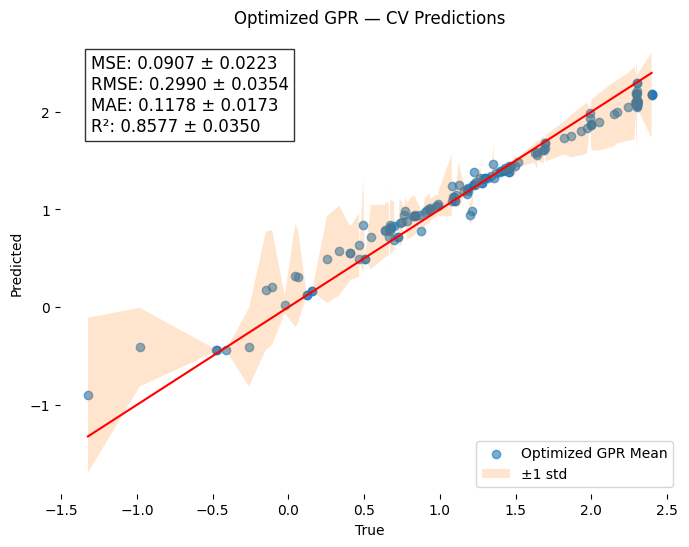


Final optimized GPR model trained on full dataset.

All files saved: final_gpr.pkl, scaler.pkl, x_cols.csv


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle  # to save model and scaler

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# -----------------------------
# 1️⃣ Standard Scaling
# -----------------------------
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(feature1),
    columns=feature1.columns,
    index=feature1.index
)

df2 = pd.concat([X_scaled, target], axis=1)
X = X_scaled.values
y = target.values

# -----------------------------
# Save feature columns
# -----------------------------
x_cols = list(feature1.columns)
pd.DataFrame({'feature': x_cols}).to_csv('x_cols.csv', index=False)

# -----------------------------
# 2️⃣ Hyperparameter Search Space
# -----------------------------
search_space = [
    Real(1e-3, 10.0,    name="kernel_scale"),   # amplitude of kernel
    Real(1e-3, 10.0,    name="length_scale"),   # RBF length scale
    Real(1e-8, 1e-2,    name="alpha"),          # noise term
    Integer(1, 10,      name="n_restarts")      # optimizer restarts
]

K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)

# -----------------------------
# 3️⃣ Objective: Minimize CV RMSE
# -----------------------------
@use_named_args(search_space)
def objective(kernel_scale, length_scale, alpha, n_restarts):
    fold_rmses = []
    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        kernel = C(kernel_scale) * RBF(length_scale)
        gpr = GaussianProcessRegressor(
            kernel=kernel,
            alpha=alpha,
            normalize_y=True,
            n_restarts_optimizer=n_restarts,
            random_state=42
        )
        gpr.fit(X_train, y_train)
        preds = gpr.predict(X_valid)
        rmse = np.sqrt(mean_squared_error(y_valid, preds))
        fold_rmses.append(rmse)

    return np.mean(fold_rmses)

# -----------------------------
# 4️⃣ Run Bayesian Optimization
# -----------------------------
print("🔎 Running Bayesian hyperparameter optimization...")
result = gp_minimize(
    objective,
    search_space,
    n_calls=40,
    random_state=42,
    verbose=True
)

best_kernel_scale, best_length_scale, best_alpha, best_n_restarts = result.x
print("\nBest hyperparameters found:")
print(f"  kernel_scale = {best_kernel_scale}")
print(f"  length_scale = {best_length_scale}")
print(f"  alpha        = {best_alpha}")
print(f"  n_restarts   = {best_n_restarts}")

# -----------------------------
# 5️⃣ Build Optimized Kernel
# -----------------------------
best_kernel = C(best_kernel_scale) * RBF(best_length_scale)

# -----------------------------
# 6️⃣ K-Fold CV Using Optimized GPR
# -----------------------------
cv_preds_all = []
for fold, (train_idx, valid_idx) in enumerate(kf.split(df2), 1):
    print(f"Training fold {fold}/{K} with optimized GPR...")
    X_train, X_valid = X[train_idx], X[valid_idx]
    y_train = y[train_idx]

    gpr = GaussianProcessRegressor(
        kernel=best_kernel,
        alpha=best_alpha,
        normalize_y=True,
        n_restarts_optimizer=best_n_restarts,
        random_state=42
    )
    gpr.fit(X_train, y_train)
    preds = gpr.predict(X)
    cv_preds_all.append(preds)

cv_preds_all = np.array(cv_preds_all).T
y_pred_mean = cv_preds_all.mean(axis=1)
y_pred_std = cv_preds_all.std(axis=1)
y_true = y.copy()

# -----------------------------
# 7️⃣ Metrics
# -----------------------------
fold_metrics = []
for fold_preds in cv_preds_all.T:
    fold_mse = mean_squared_error(y_true, fold_preds)
    fold_rmse = np.sqrt(fold_mse)
    fold_mae = mean_absolute_error(y_true, fold_preds)
    fold_r2 = r2_score(y_true, fold_preds)
    fold_metrics.append([fold_mse, fold_rmse, fold_mae, fold_r2])

fold_metrics = np.array(fold_metrics)
mse_mean, rmse_mean, mae_mean, r2_mean = fold_metrics.mean(axis=0)
mse_std, rmse_std, mae_std, r2_std = fold_metrics.std(axis=0)

metrics_text = (
    f"MSE: {mse_mean:.4f} ± {mse_std:.4f}\n"
    f"RMSE: {rmse_mean:.4f} ± {rmse_std:.4f}\n"
    f"MAE: {mae_mean:.4f} ± {mae_std:.4f}\n"
    f"R²: {r2_mean:.4f} ± {r2_std:.4f}"
)
print("\nCross-validation metrics (optimized GPR):")
print(metrics_text)

# -----------------------------
# 8️⃣ Smooth Plot
# -----------------------------
sorted_idx = np.argsort(y_true)
plt.figure(figsize=(8, 6))
plt.scatter(y_true[sorted_idx], y_pred_mean[sorted_idx], alpha=0.6, label='Optimized GPR Mean')
plt.fill_between(
    y_true[sorted_idx],
    y_pred_mean[sorted_idx] - y_pred_std[sorted_idx],
    y_pred_mean[sorted_idx] + y_pred_std[sorted_idx],
    alpha=0.2, label='±1 std'
)
plt.plot(y_true[sorted_idx], y_true[sorted_idx], color='red')
plt.title("Optimized GPR — CV Predictions")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.text(0.05, 0.95, metrics_text, transform=plt.gca().transAxes,
         fontsize=12, va='top', bbox=dict(facecolor='white', alpha=0.8))
plt.legend()
plt.grid(False)
plt.box(False)
plt.show()

# -----------------------------
# 9️⃣ Final GPR on Full Data
# -----------------------------
final_gpr = GaussianProcessRegressor(
    kernel=best_kernel,
    alpha=best_alpha,
    normalize_y=True,
    n_restarts_optimizer=best_n_restarts,
    random_state=42
)
final_gpr.fit(X, y)
print("\nFinal optimized GPR model trained on full dataset.")

# -----------------------------
# 10️⃣ Save all components for future predictions
# -----------------------------
# Save model
with open('final_gpr.pkl', 'wb') as f:
    pickle.dump(final_gpr, f)

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nAll files saved: final_gpr.pkl, scaler.pkl, x_cols.csv")


In [ ]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import pickle

# -----------------------------
# Load saved components
# -----------------------------
with open('final_gpr.pkl', 'rb') as f:
    model = pickle.load(f)

with open('scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

x_cols = pd.read_csv('x_cols.csv')['feature'].tolist()

# -----------------------------
# Function to compute Morgan fingerprint
# -----------------------------
def smiles_to_fp(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.full(nBits, np.nan)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    arr = np.zeros((nBits,), dtype=int)
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# -----------------------------
# Prediction function
# -----------------------------
def predict_smiles(smiles_list):
    # Compute fingerprints
    fps = np.array([smiles_to_fp(smi) for smi in smiles_list])
    df = pd.DataFrame(fps, columns=[f'FP_{i}' for i in range(fps.shape[1])])
    # Reorder to match training features
    df = df[x_cols]
    # Scale features
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=x_cols)
    # Predict
    preds = model.predict(df_scaled.values)
    # Convert back if target was log10-transformed
    preds_original = 10 ** preds
    return pd.DataFrame({'SMILES': smiles_list, 'Predicted': preds_original})

# -----------------------------
# Example usage
# -----------------------------
smiles_list = ['CCCCCCC#CC1=CN=CC(N2CCC3(CN(C(C4=CC([N+]([O-])=O)=CC([N+]([O-])=O)=C4)=O)C3)C2)=C1']
predictions = predict_smiles(smiles_list)
print(predictions)


                                              SMILES  Predicted
0  CCCCCCC#CC1=CN=CC(N2CCC3(CN(C(C4=CC([N+]([O-])...   6.978049


[21:30:49] DEPRECATION WARNING: please use MorganGenerator


# Model_explannation

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e43554c9f31a1eb56e76971190544465ef55d4dd8133b2bd212bd41d20a5f21c
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
from IPython.display import SVG # to use Scalar Vector Graphics (SVG) not bitmaps, for cleaner lines

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw # to draw molecules
from rdkit.Chem.Draw import IPythonConsole # to draw inline in iPython
from rdkit.Chem import rdDepictor  # to generate 2D depictions of molecules
from rdkit.Chem.Draw import rdMolDraw2D # to draw 2D molecules using vectors

from rdkit.Chem.MolStandardize import rdMolStandardize

In [ ]:
df

,Identifier,Canonical SMILES,IC50 uM,PIC50,valid_smiles,cleanedMol,Molecule,Fingerprint,UMAP1,UMAP2,...,FP_1014,FP_1015,FP_1016,FP_1017,FP_1018,FP_1019,FP_1020,FP_1021,FP_1022,FP_1023
0,TB-VS0012,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N2C)=...,5.300,5.275724,True,CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1,<rdkit.Chem.rdchem.Mol object at 0x7b91e0330430>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",21.375677,14.751518,...,0,0,0,0,0,0,0,0,0,0
1,TB-VS12-2,BrC1=CC(C2=NN=C(N2C)S)=CN=C1,200.000,3.698970,True,Cn1c(-c2cncc(Br)c2)n[nH]c1=S,<rdkit.Chem.rdchem.Mol object at 0x7b91e0331770>,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",21.322189,13.113513,...,0,0,0,0,0,0,0,0,0,0
2,TB-VS12-3,BrC1=CC(C2=NN=C(N2C)SCC3=CC=C(C=C3)Cl)=CN=C1,200.000,3.698970,True,Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cncc(Br)c1,<rdkit.Chem.rdchem.Mol object at 0x7b91e0331460>,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...",20.493898,15.043191,...,0,0,0,0,0,0,0,0,0,0
3,TB-VS12-4,CCCCCCC#CC1=CC(C2=NN=C(N2C)S)=CN=C1,22.570,4.646468,True,CCCCCCC#Cc1cncc(-c2n[nH]c(=S)n2C)c1,<rdkit.Chem.rdchem.Mol object at 0x7b91e03315b0>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",21.278896,13.182528,...,0,0,0,0,0,0,0,0,0,0
4,TB-VS12-5,CCCCCCC#CC1=CC(C2=NN=C(SCC3=CC=CC=C3)N2C)=CN=C1,175.000,3.756962,True,CCCCCCC#Cc1cncc(-c2nnc(SCc3ccccc3)n2C)c1,<rdkit.Chem.rdchem.Mol object at 0x7b91e03314d0>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",20.927437,14.580971,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,ROY-0000175-001,CC(OC(N(C1)CC21CCN(C3=CC(C#CC4=CC=CC=C4)=CN=C3...,6.843,5.164753,True,CC(C)(C)OC(=O)N1CC2(CCN(c3cncc(C#Cc4ccccc4)c3)...,<rdkit.Chem.rdchem.Mol object at 0x7b91e0301cb0>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20.469419,15.524208,...,0,0,0,0,0,0,0,0,0,0
161,ROY-0000223-001,ClC(C=C1)=CC=C1CO[C@H](CC2)CN2C3=CC(C#CC4=CC=C...,5.615,5.250650,True,FC(F)(F)Oc1ccc(C#Cc2cncc(N3CC[C@@H](OCc4ccc(Cl...,<rdkit.Chem.rdchem.Mol object at 0x7b91e0301f50>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22.862667,13.353951,...,0,0,0,0,1,1,0,0,0,0
162,ROY-0000222-001,ClC(C=C1)=CC=C1CO[C@H](CC2)CN2C3=CC(C#CC4=CC=C...,9.705,5.013004,True,Clc1ccc(CO[C@@H]2CCN(c3cncc(C#Cc4ccccc4)c3)C2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7b91e0301e70>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22.837101,13.422137,...,0,0,0,0,1,1,0,0,0,0
163,ROY-0000225-001,CC(OC(N1CC(OCCCC2=CC=CC=C2)C1)=O)(C)C,148.000,3.829738,True,CC(C)(C)OC(=O)N1CC(OCCCc2ccccc2)C1,<rdkit.Chem.rdchem.Mol object at 0x7b91e0302110>,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20.433498,15.111303,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
import pandas as pd

# Assuming df and df2 already exist

# Get the 'cleanedMol' column
smiles_col = df['cleanedMol']

# Insert it as the first column in df2
df2.insert(0, 'cleanedMol', smiles_col)

# Check the result
df2

,cleanedMol,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,FP_10,FP_11,...,FP_1015,FP_1016,FP_1017,FP_1018,FP_1019,FP_1020,FP_1021,FP_1022,FP_1023,transformed_IC50
0,CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1,0.0,0.0,-0.176777,0.0,0.0,1.288911,-0.176777,-0.176777,-0.240192,...,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0,0.724276
1,Cn1c(-c2cncc(Br)c2)n[nH]c1=S,0.0,0.0,5.656854,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,...,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0,2.301030
2,Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cncc(Br)c1,0.0,0.0,5.656854,0.0,0.0,1.288911,-0.176777,-0.176777,-0.240192,...,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0,2.301030
3,CCCCCCC#Cc1cncc(-c2n[nH]c(=S)n2C)c1,0.0,0.0,-0.176777,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,...,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0,1.353532
4,CCCCCCC#Cc1cncc(-c2nnc(SCc3ccccc3)n2C)c1,0.0,0.0,-0.176777,0.0,0.0,1.288911,-0.176777,-0.176777,-0.240192,...,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0,2.243038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,CC(C)(C)OC(=O)N1CC2(CCN(c3cncc(C#Cc4ccccc4)c3)...,0.0,0.0,-0.176777,0.0,0.0,-0.775849,5.656854,-0.176777,-0.240192,...,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0,0.835247
161,FC(F)(F)Oc1ccc(C#Cc2cncc(N3CC[C@@H](OCc4ccc(Cl...,0.0,0.0,-0.176777,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,...,0.0,0.0,-0.11077,5.656854,2.165561,0.0,-0.078087,-0.225733,0.0,0.749350
162,Clc1ccc(CO[C@@H]2CCN(c3cncc(C#Cc4ccccc4)c3)C2)cc1,0.0,0.0,-0.176777,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,...,0.0,0.0,-0.11077,5.656854,2.165561,0.0,-0.078087,-0.225733,0.0,0.986996
163,CC(C)(C)OC(=O)N1CC(OCCCc2ccccc2)C1,0.0,0.0,-0.176777,0.0,0.0,-0.775849,5.656854,-0.176777,-0.240192,...,0.0,0.0,-0.11077,-0.176777,2.165561,0.0,-0.078087,-0.225733,0.0,2.170262


In [ ]:
X_train_scaled = df2.loc[:, 'FP_3':]

In [ ]:
X_train_scaled.drop(columns=['transformed_IC50'])

,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,FP_10,FP_11,FP_12,...,FP_1014,FP_1015,FP_1016,FP_1017,FP_1018,FP_1019,FP_1020,FP_1021,FP_1022,FP_1023
0,0.0,0.0,-0.176777,0.0,0.0,1.288911,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
1,0.0,0.0,5.656854,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
2,0.0,0.0,5.656854,0.0,0.0,1.288911,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
3,0.0,0.0,-0.176777,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
4,0.0,0.0,-0.176777,0.0,0.0,1.288911,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0.0,0.0,-0.176777,0.0,0.0,-0.775849,5.656854,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
161,0.0,0.0,-0.176777,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,5.656854,2.165561,0.0,-0.078087,-0.225733,0.0
162,0.0,0.0,-0.176777,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,5.656854,2.165561,0.0,-0.078087,-0.225733,0.0
163,0.0,0.0,-0.176777,0.0,0.0,-0.775849,5.656854,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,2.165561,0.0,-0.078087,-0.225733,0.0


In [ ]:
df_withFeatures_test=df2

In [ ]:
df_withFeatures_test.drop(columns=['transformed_IC50'])

,cleanedMol,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,FP_10,FP_11,...,FP_1014,FP_1015,FP_1016,FP_1017,FP_1018,FP_1019,FP_1020,FP_1021,FP_1022,FP_1023
0,CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1,0.0,0.0,-0.176777,0.0,0.0,1.288911,-0.176777,-0.176777,-0.240192,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
1,Cn1c(-c2cncc(Br)c2)n[nH]c1=S,0.0,0.0,5.656854,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
2,Cn1c(SCc2ccc(Cl)cc2)nnc1-c1cncc(Br)c1,0.0,0.0,5.656854,0.0,0.0,1.288911,-0.176777,-0.176777,-0.240192,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
3,CCCCCCC#Cc1cncc(-c2n[nH]c(=S)n2C)c1,0.0,0.0,-0.176777,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
4,CCCCCCC#Cc1cncc(-c2nnc(SCc3ccccc3)n2C)c1,0.0,0.0,-0.176777,0.0,0.0,1.288911,-0.176777,-0.176777,-0.240192,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,CC(C)(C)OC(=O)N1CC2(CCN(c3cncc(C#Cc4ccccc4)c3)...,0.0,0.0,-0.176777,0.0,0.0,-0.775849,5.656854,-0.176777,-0.240192,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
161,FC(F)(F)Oc1ccc(C#Cc2cncc(N3CC[C@@H](OCc4ccc(Cl...,0.0,0.0,-0.176777,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,...,-0.176777,0.0,0.0,-0.11077,5.656854,2.165561,0.0,-0.078087,-0.225733,0.0
162,Clc1ccc(CO[C@@H]2CCN(c3cncc(C#Cc4ccccc4)c3)C2)cc1,0.0,0.0,-0.176777,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,...,-0.176777,0.0,0.0,-0.11077,5.656854,2.165561,0.0,-0.078087,-0.225733,0.0
163,CC(C)(C)OC(=O)N1CC(OCCCc2ccccc2)C1,0.0,0.0,-0.176777,0.0,0.0,-0.775849,5.656854,-0.176777,-0.240192,...,-0.176777,0.0,0.0,-0.11077,-0.176777,2.165561,0.0,-0.078087,-0.225733,0.0


In [ ]:
X_test=df_withFeatures_test.drop(columns=['cleanedMol'])

In [ ]:
tpot_column = list(df_withFeatures_test.columns)

In [ ]:
tpot_column = list(X_test.columns)


In [ ]:
tpot_column

['FP_3',
 'FP_4',
 'FP_5',
 'FP_6',
 'FP_7',
 'FP_8',
 'FP_9',
 'FP_10',
 'FP_11',
 'FP_12',
 'FP_13',
 'FP_14',
 'FP_15',
 'FP_16',
 'FP_17',
 'FP_18',
 'FP_19',
 'FP_20',
 'FP_21',
 'FP_22',
 'FP_23',
 'FP_24',
 'FP_25',
 'FP_26',
 'FP_27',
 'FP_28',
 'FP_29',
 'FP_30',
 'FP_31',
 'FP_32',
 'FP_33',
 'FP_34',
 'FP_35',
 'FP_36',
 'FP_37',
 'FP_38',
 'FP_39',
 'FP_40',
 'FP_41',
 'FP_42',
 'FP_43',
 'FP_44',
 'FP_45',
 'FP_46',
 'FP_47',
 'FP_48',
 'FP_49',
 'FP_50',
 'FP_51',
 'FP_52',
 'FP_53',
 'FP_54',
 'FP_55',
 'FP_56',
 'FP_57',
 'FP_58',
 'FP_59',
 'FP_60',
 'FP_61',
 'FP_62',
 'FP_63',
 'FP_64',
 'FP_65',
 'FP_66',
 'FP_67',
 'FP_68',
 'FP_69',
 'FP_70',
 'FP_71',
 'FP_72',
 'FP_73',
 'FP_74',
 'FP_75',
 'FP_76',
 'FP_77',
 'FP_78',
 'FP_79',
 'FP_80',
 'FP_81',
 'FP_82',
 'FP_83',
 'FP_84',
 'FP_85',
 'FP_86',
 'FP_87',
 'FP_88',
 'FP_89',
 'FP_90',
 'FP_91',
 'FP_92',
 'FP_93',
 'FP_94',
 'FP_95',
 'FP_96',
 'FP_97',
 'FP_98',
 'FP_99',
 'FP_100',
 'FP_101',
 'FP_102',
 'FP

In [ ]:
df_withFeatures_test=df_withFeatures_test.drop(columns=['transformed_IC50'])

In [ ]:
X_train_scaled=X_train_scaled.drop(columns=['transformed_IC50'])

In [ ]:
X_train_scaled

,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,FP_10,FP_11,FP_12,...,FP_1014,FP_1015,FP_1016,FP_1017,FP_1018,FP_1019,FP_1020,FP_1021,FP_1022,FP_1023
0,0.0,0.0,-0.176777,0.0,0.0,1.288911,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
1,0.0,0.0,5.656854,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
2,0.0,0.0,5.656854,0.0,0.0,1.288911,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
3,0.0,0.0,-0.176777,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
4,0.0,0.0,-0.176777,0.0,0.0,1.288911,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0.0,0.0,-0.176777,0.0,0.0,-0.775849,5.656854,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
161,0.0,0.0,-0.176777,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,5.656854,2.165561,0.0,-0.078087,-0.225733,0.0
162,0.0,0.0,-0.176777,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,5.656854,2.165561,0.0,-0.078087,-0.225733,0.0
163,0.0,0.0,-0.176777,0.0,0.0,-0.775849,5.656854,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,2.165561,0.0,-0.078087,-0.225733,0.0


In [ ]:
X_train_scaled

,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,FP_10,FP_11,FP_12,...,FP_1014,FP_1015,FP_1016,FP_1017,FP_1018,FP_1019,FP_1020,FP_1021,FP_1022,FP_1023
0,0.0,0.0,-0.176777,0.0,0.0,1.288911,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
1,0.0,0.0,5.656854,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
2,0.0,0.0,5.656854,0.0,0.0,1.288911,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
3,0.0,0.0,-0.176777,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
4,0.0,0.0,-0.176777,0.0,0.0,1.288911,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,0.0,0.0,-0.176777,0.0,0.0,-0.775849,5.656854,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,-0.461774,0.0,-0.078087,-0.225733,0.0
161,0.0,0.0,-0.176777,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,5.656854,2.165561,0.0,-0.078087,-0.225733,0.0
162,0.0,0.0,-0.176777,0.0,0.0,-0.775849,-0.176777,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,5.656854,2.165561,0.0,-0.078087,-0.225733,0.0
163,0.0,0.0,-0.176777,0.0,0.0,-0.775849,5.656854,-0.176777,-0.240192,0.0,...,-0.176777,0.0,0.0,-0.11077,-0.176777,2.165561,0.0,-0.078087,-0.225733,0.0


[21:31:17] DEPRECATION WARNING: please use MorganGenerator
[21:31:17] DEPRECATION WARNING: please use MorganGenerator
[21:31:17] DEPRECATION WARNING: please use MorganGenerator
[21:31:17] DEPRECATION WARNING: please use MorganGenerator
[21:31:17] DEPRECATION WARNING: please use MorganGenerator
[21:31:17] DEPRECATION WARNING: please use MorganGenerator
[21:31:17] DEPRECATION WARNING: please use MorganGenerator
[21:31:17] DEPRECATION WARNING: please use MorganGenerator
[21:31:17] DEPRECATION WARNING: please use MorganGenerator
[21:31:17] DEPRECATION WARNING: please use MorganGenerator
[21:31:17] DEPRECATION WARNING: please use MorganGenerator
[21:31:17] DEPRECATION WARNING: please use MorganGenerator
[21:31:17] DEPRECATION WARNING: please use MorganGenerator
[21:31:17] DEPRECATION WARNING: please use MorganGenerator
[21:31:17] DEPRECATION WARNING: please use MorganGenerator
[21:31:17] DEPRECATION WARNING: please use MorganGenerator
[21:31:17] DEPRECATION WARNING: please use MorganGenerat

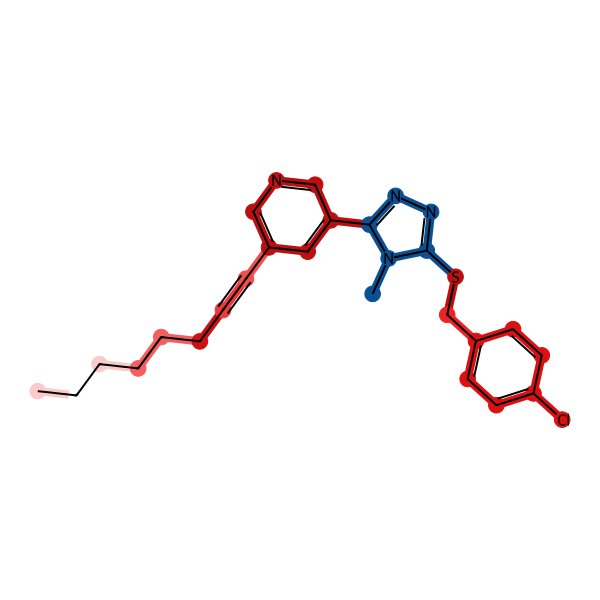

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image
import io
import colorsys
from lime import lime_tabular
from sklearn.preprocessing import StandardScaler

# -------------------
# Helper functions
# -------------------
def weight_to_google_color(weight, max_abs_weight):
    if max_abs_weight == 0:
        lightness = 0.5
    else:
        lightness = 0.3 + 0.7 * abs(weight) / max_abs_weight
    hue = 210/360 if weight >= 0 else 0/360
    saturation = 0.85
    r, g, b = colorsys.hls_to_rgb(hue, lightness, saturation)
    return (r, g, b)

def draw_molecule_with_weights(mol, atom_weights):
    drawer = rdMolDraw2D.MolDraw2DCairo(600, 600)
    options = drawer.drawOptions()
    options.atomHighlightsAreCircles = True
    if not atom_weights:
        return None
    weights = list(atom_weights.values())
    max_abs = max(abs(w) for w in weights)
    highlight_atoms = list(atom_weights.keys())
    highlight_colors = {idx: weight_to_google_color(atom_weights[idx], max_abs)
                        for idx in highlight_atoms}
    drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms, highlightAtomColors=highlight_colors)
    drawer.FinishDrawing()
    png = drawer.GetDrawingText()
    img = Image.open(io.BytesIO(png))
    return img

def map_fragment_weights_to_atoms(parent_molecule, fragment_df):
    atom_weights = {}
    for _, row in fragment_df.iterrows():
        frag_smiles = row['Fragment_SMILES']
        frag_weight = row['Fragment_Weight']
        frag_mol = Chem.MolFromSmiles(frag_smiles)
        if frag_mol is None:
            continue
        if parent_molecule.HasSubstructMatch(frag_mol):
            match_atoms = parent_molecule.GetSubstructMatch(frag_mol)
            for atom_idx in match_atoms:
                atom_weights[atom_idx] = atom_weights.get(atom_idx, 0) + frag_weight
    return atom_weights

def generate_circular_fingerprint_dict(mol, radius=4, nBits=1024):
    bit_info = {}
    AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, bitInfo=bit_info)
    fragments_dict = {}
    for bit_idx, info_list in bit_info.items():
        atom_idx, rad = info_list[0]
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, atom_idx)
        submol = Chem.PathToSubmol(mol, env)
        fragments_dict[bit_idx] = submol
    return fragments_dict

def calculate_circular_fingerprint(smiles, radius=4, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(nBits)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    arr = np.zeros((nBits,), dtype=int)
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# -------------------
# Prepare test fingerprints and scaled features
# -------------------
fingerprint_array_test = np.array([
    calculate_circular_fingerprint(smi, radius=4, nBits=1024)
    for smi in df_withFeatures_test['cleanedMol']
])

X_test = pd.DataFrame(
    fingerprint_array_test,
    columns=[f'FP_{i}' for i in range(fingerprint_array_test.shape[1])]
)

# Scale test features using same scaler (or fit new one if needed)
scaler = StandardScaler()
X_test_scaled = pd.DataFrame(
    scaler.fit_transform(X_test),
    columns=X_test.columns
)

# Ensure columns match training
X_test_scaled = X_test_scaled[X_train_scaled.columns]

# -------------------
# LIME Explainer
# -------------------
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled.values,
    feature_names=X_train_scaled.columns.tolist(),
    categorical_features=[],
    mode='regression',
    discretize_continuous=True
)

# -------------------
# Evaluator for trained GPR
# -------------------
def best_model_evaluator(x):
    return final_gpr.predict(x)

# -------------------
# Select single molecule (index 0)
# -------------------
i = 0
smi = df_withFeatures_test['cleanedMol'].iloc[i]
mol = Chem.MolFromSmiles(smi)

# Explain instance using LIME
explanation = explainer.explain_instance(
    X_test_scaled.iloc[i].values,
    best_model_evaluator,
    num_features=500
)

# Parse feature weights
feature_weights = {}
for feat_name, weight in explanation.as_list():
    if '_' in feat_name:
        bit_idx = int(feat_name.split('_')[1].split()[0])
        feature_weights[bit_idx] = weight

# Generate fingerprint fragments
fragments_activations = generate_circular_fingerprint_dict(mol)

# Build fragment DataFrame
all_data = []
for bit_idx, submol in fragments_activations.items():
    if bit_idx in feature_weights:
        all_data.append({
            'Fragment_SMILES': Chem.MolToSmiles(submol),
            'Fragment_Weight': feature_weights[bit_idx]
        })
fragment_df = pd.DataFrame(all_data)

# Map fragment weights to atoms and visualize
atom_weights = map_fragment_weights_to_atoms(mol, fragment_df)
img = draw_molecule_with_weights(mol, atom_weights)
if img:
    display(img)
    # img.save("single_molecule_fragment_vis.png")


[21:31:33] DEPRECATION WARNING: please use MorganGenerator
[21:31:33] non-ring atom 6 marked aromatic
[21:31:33] non-ring atom 0 marked aromatic
[21:31:33] non-ring atom 0 marked aromatic
[21:31:33] non-ring atom 0 marked aromatic
[21:31:33] non-ring atom 0 marked aromatic
[21:31:33] non-ring atom 0 marked aromatic
[21:31:33] non-ring atom 0 marked aromatic
[21:31:33] non-ring atom 10 marked aromatic
[21:31:33] non-ring atom 6 marked aromatic
[21:31:33] non-ring atom 0 marked aromatic
[21:31:33] non-ring atom 0 marked aromatic
[21:31:33] non-ring atom 0 marked aromatic
[21:31:33] non-ring atom 9 marked aromatic
[21:31:33] non-ring atom 0 marked aromatic
[21:31:33] non-ring atom 0 marked aromatic
[21:31:33] non-ring atom 0 marked aromatic
[21:31:33] non-ring atom 0 marked aromatic
[21:31:33] non-ring atom 0 marked aromatic
[21:31:33] non-ring atom 0 marked aromatic
[21:31:33] non-ring atom 0 marked aromatic
[21:31:33] non-ring atom 0 marked aromatic
[21:31:33] non-ring atom 0 marked aro

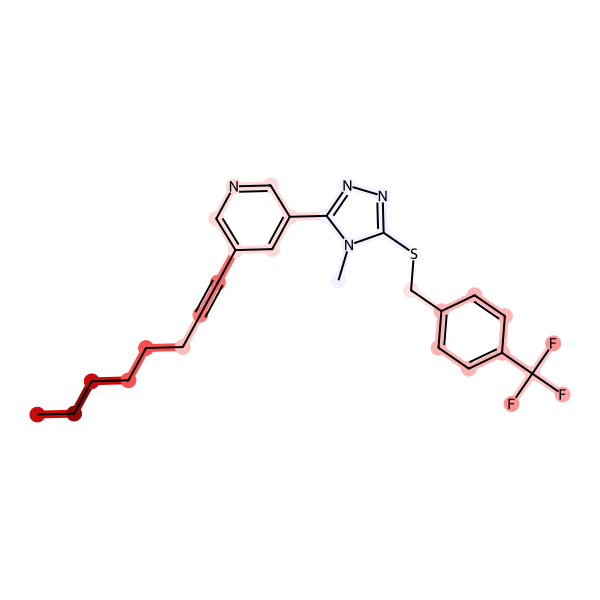

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import rdMolDraw2D
from PIL import Image
import io
from lime import lime_tabular
from sklearn.preprocessing import StandardScaler
import colorsys

# -------------------
# Coloring function: red for negative, blue for positive
# -------------------
def weight_to_color(weight, max_abs_weight):
    """
    Map weight to RGB color:
    - Positive weights → blue
    - Negative weights → red
    - Color intensity scales with absolute weight
    """
    if max_abs_weight == 0:
        return (0.8, 0.8, 0.8)  # light gray for zero weights

    norm = abs(weight) / max_abs_weight  # normalize 0-1
    lightness = 1 - 0.7 * norm           # 1 = very light, 0.3 = vivid
    saturation = 0.9
    hue = 240/360 if weight >= 0 else 0/360  # blue or red
    r, g, b = colorsys.hls_to_rgb(hue, lightness, saturation)
    return (r, g, b)

# -------------------
# Draw molecule with atom weights
# -------------------
def draw_molecule_with_weights(mol, atom_weights, size=600):
    if not atom_weights:
        return None
    drawer = rdMolDraw2D.MolDraw2DCairo(size, size)
    options = drawer.drawOptions()
    options.atomHighlightsAreCircles = True

    highlight_atoms = list(atom_weights.keys())
    max_abs = max(abs(w) for w in atom_weights.values())
    highlight_colors = {idx: weight_to_color(atom_weights[idx], max_abs) for idx in highlight_atoms}

    drawer.DrawMolecule(mol, highlightAtoms=highlight_atoms, highlightAtomColors=highlight_colors)
    drawer.FinishDrawing()
    png = drawer.GetDrawingText()
    img = Image.open(io.BytesIO(png))
    return img

# -------------------
# Map fragment weights to atom weights
# -------------------
def map_fragment_weights_to_atoms(parent_mol, fragment_df):
    atom_weights = {}
    for _, row in fragment_df.iterrows():
        frag_smiles = row['Fragment_SMILES']
        frag_weight = row['Fragment_Weight']
        frag_mol = Chem.MolFromSmiles(frag_smiles)
        if frag_mol is None:
            continue
        if parent_mol.HasSubstructMatch(frag_mol):
            match_atoms = parent_mol.GetSubstructMatch(frag_mol)
            for idx in match_atoms:
                atom_weights[idx] = atom_weights.get(idx, 0) + frag_weight
    return atom_weights

# -------------------
# Generate circular fingerprint fragments
# -------------------
def generate_circular_fingerprint_dict(mol, radius=4, nBits=1024):
    bit_info = {}
    AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, bitInfo=bit_info)
    fragments_dict = {}
    for bit_idx, info_list in bit_info.items():
        atom_idx, rad = info_list[0]
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, atom_idx)
        submol = Chem.PathToSubmol(mol, env)
        fragments_dict[bit_idx] = submol
    return fragments_dict

# -------------------
# Example usage for a single molecule
# -------------------
# Index of molecule to visualize
i = 10
smi = df_withFeatures_test['cleanedMol'].iloc[i]
mol = Chem.MolFromSmiles(smi)

# Explain instance using LIME
explanation = explainer.explain_instance(
    X_test_scaled.iloc[i].values,
    best_model_evaluator,
    num_features=500
)

# Parse LIME feature weights
feature_weights = {}
for feat_name, weight in explanation.as_list():
    if '_' in feat_name:
        bit_idx = int(feat_name.split('_')[1].split()[0])
        feature_weights[bit_idx] = weight

# Generate fingerprint fragments
fragments_dict = generate_circular_fingerprint_dict(mol)

# Build fragment DataFrame
fragment_df = pd.DataFrame([
    {'Fragment_SMILES': Chem.MolToSmiles(submol), 'Fragment_Weight': feature_weights[bit_idx]}
    for bit_idx, submol in fragments_dict.items()
    if bit_idx in feature_weights
])

# Map fragment weights to atoms and draw molecule
atom_weights = map_fragment_weights_to_atoms(mol, fragment_df)
img = draw_molecule_with_weights(mol, atom_weights)
if img:
    display(img)
    # Optionally save: img.save("molecule_fragments.png")


In [ ]:
# First, install exmol if not already:
!pip install exmol

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 29.1 MB/s eta 0:00:00
  Created wheel for ratelimit: filename=ratelimit-2.2.1-py3-none-any.whl size=5893 sha256=3a7246649529b337a521d4767cb4f4a94dd1a6d1756a462c912f0b5b47bcc566
  Stored in directory: /root/.cache/pip/wheels/69/bd/e0/4a5dee2a1bfbc8e258f543f92940e2b494d63b5be8144ec8c4
Successfully built ratelimit


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/tmp/ipython-input-3651883495.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(best_model_evaluator(X_aligned.values.reshape(1, -1)))
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/tmp/ipython-input-3651883495.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(best_model_evaluato

Base molecule SMILES: CCCCCCC#Cc1cncc(-c2nnc(SCc3ccc(Cl)cc3)n2C)c1
Base prediction: 0.9978723900348252


😀Calling your model function😀: 100%|██████████| 100/100 [00:00<00:00, 125.88it/s]/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/tmp/ipython-input-3651883495.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(best_model_evaluator(X_aligned.values.reshape(1, -1)))
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/tmp/ipython-input-3651883495.py:38: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before perfo

,SMILES,Predicted,Similarity_to_base,Delta_prediction
0,CCCCCCC#CC1=CN=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N2...,0.997872,1.000000,0.000000
1,C(C)CCCC#CC1=CN=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N...,1.325263,0.964286,0.327390
2,C(C)CCCC#CC1=CN=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N...,1.325263,0.964286,0.327390
3,C(C1=CN=CC(C2=NN=C(SCC3=CC=C(Cl)C=C3)N2C)=C1)#...,1.341015,0.838710,0.343142
4,C1(C2=CC(C#CCCCCC)=NN=C2)=NN=C(SCC2=CC=C(Cl)C=...,1.341354,0.755319,0.343482
5,C1=C(C2=NN=CN2SCC2=CC=C(Cl)C=C2)C=C(C#CCCCCCC)...,1.341073,0.729167,0.343201


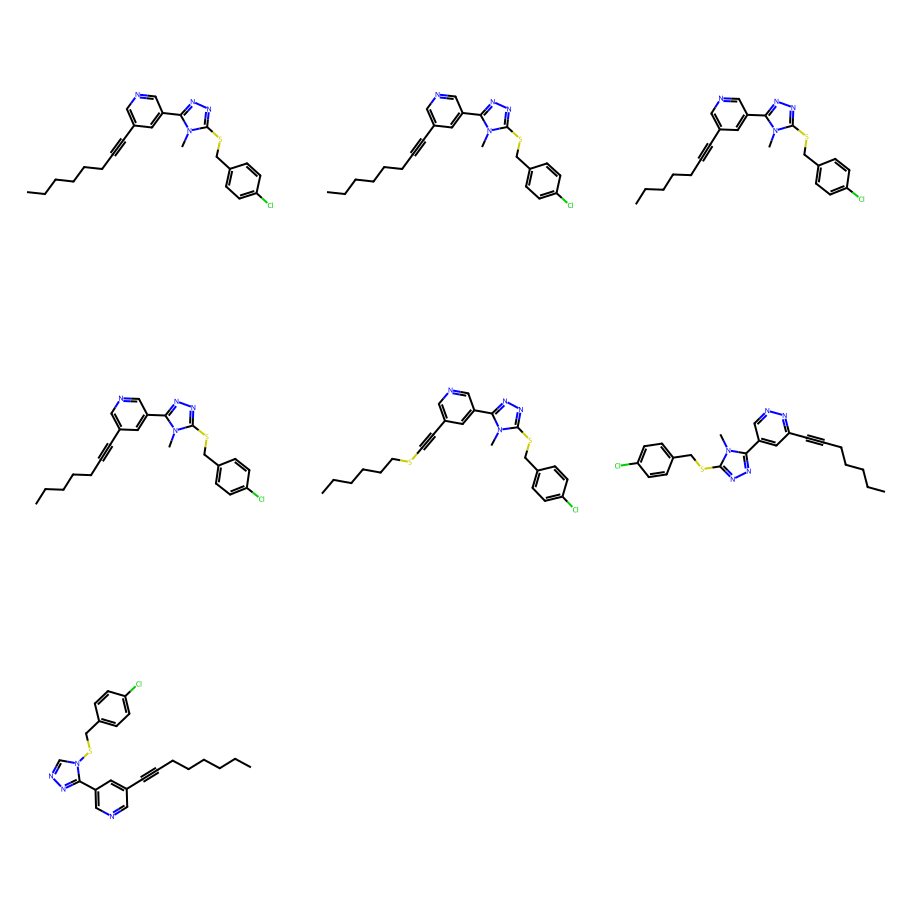

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import exmol

# -------------------
# 1️⃣ Fingerprint functions
# -------------------
def calculate_circular_fingerprint(smiles, radius=4, nBits=1024):
    """
    Converts SMILES to Morgan fingerprint (bit vector).
    """
    smiles = str(smiles)  # ensure string
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(nBits)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits)
    arr = np.zeros((nBits,), dtype=int)
    AllChem.DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# -------------------
# 2️⃣ Single-molecule model predictor
# -------------------
def model_predict(smiles: str):
    """
    Single SMILES → fingerprint → scaled → aligned → model prediction
    """
    fp = calculate_circular_fingerprint(smiles, radius=4, nBits=1024)
    X = pd.Series(fp, index=[f'FP_{i}' for i in range(len(fp))])
    # Transform
    X_scaled = pd.DataFrame(scaler.transform([X]), columns=X.index)
    # Align with training
    X_aligned = X_scaled[X_train_scaled.columns]
    return float(best_model_evaluator(X_aligned.values.reshape(1, -1)))

# -------------------
# 3️⃣ Batched wrapper for ExMol
# -------------------
def model_predict_batched(smiles_list):
    """
    Batched version of model_predict for ExMol
    """
    return np.array([model_predict(smi) for smi in smiles_list])

# -------------------
# 4️⃣ Prepare test set fingerprints
# -------------------
fingerprint_array_test = np.array([
    calculate_circular_fingerprint(str(smi), radius=4, nBits=1024)
    for smi in df_withFeatures_test['cleanedMol']
])
X_test = pd.DataFrame(fingerprint_array_test, columns=[f'FP_{i}' for i in range(fingerprint_array_test.shape[1])])

# Fit scaler on training (or reuse existing)
scaler = StandardScaler()
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns=X_test.columns)
X_test_scaled = X_test_scaled[X_train_scaled.columns]  # align columns
X_train_scaled_aligned = X_train_scaled  # for background if needed

# -------------------
# 5️⃣ Select base molecule
# -------------------
i = 0
base_smi = str(df_withFeatures_test['cleanedMol'].iloc[i])
print("Base molecule SMILES:", base_smi)
print("Base prediction:", model_predict(base_smi))

# -------------------
# 6️⃣ Generate chemical space with ExMol
# -------------------
space = exmol.sample_space(
    base_smi,
    model_predict_batched,  # batched model
    num_samples=100,
    preset='medium'
)

# -------------------
# 7️⃣ Generate top counterfactuals
# -------------------
cfs = exmol.cf_explain(space, nmols=5)

# -------------------
# 8️⃣ Display counterfactual info
# -------------------
cf_data = []
for cf in cfs:
    cf_data.append({
        "SMILES": cf.smiles,
        "Predicted": cf.yhat,
        "Similarity_to_base": cf.similarity,
        "Delta_prediction": cf.yhat - model_predict(base_smi)
    })
cf_df = pd.DataFrame(cf_data)
display(cf_df)

# -------------------
# 9️⃣ Visualize base + counterfactual molecules
# -------------------
mols = [Chem.MolFromSmiles(base_smi)] + [Chem.MolFromSmiles(cf.smiles) for cf in cfs]
img = Draw.MolsToGridImage(mols, molsPerRow=3, subImgSize=(300, 300))
display(img)
# Optionally save
# img.save("counterfactual_molecules.png")
